In [1]:
%load_ext autoreload

import os, sys
sys.path.insert(0, "../")

%autoreload 2
from flowset import *

import polars as pl

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


In [2]:
def download_and_unzip(download_url_link, dir_path, zipped_filename,destination_dir_name):
    #https://www.tutorialsbuddy.com/download-and-unzip-a-zipped-file-in-python
    print("Download starting")
    urllib.request.urlretrieve(
        download_url_link, os.path.join(dir_path, zipped_filename)
    )
    print("Download complete")

    print("unzipping file starting")
    with zipfile.ZipFile(os.path.join(dir_path, zipped_filename), "r") as zip_file:
        zip_file.extractall(os.path.join(dir_path, destination_dir_name))
    print("unzipping complete")


if not os.path.exists("ReactomePathways.gmt"):
    download_and_unzip("https://reactome.org/download/current/ReactomePathways.gmt.zip", ".", "ReactomePathways.gmt.zip", ".")

In [3]:
exprData = pl.read_csv("sccovid_data/expression.mono.asympt.tsv", has_header=True, separator="\t", null_values=["NA"])
exprData = exprData.filter( pl.col("cluster") != "cluster.0")
print(exprData)

#print(exprData.select("cluster").unique())

shape: (40_795, 13)
┌───────────┬────────────┬───────────┬────────────┬───┬────────────┬──────────┬────────────┬────────────┐
│ cluster   ┆ count_expr ┆ min.clust ┆ lower_hing ┆ … ┆ count_all. ┆ gene     ┆ not_expr.c ┆ expr.clust │
│ ---       ┆ .cluster   ┆ er        ┆ e.cluster  ┆   ┆ cluster    ┆ ---      ┆ luster     ┆ er         │
│ str       ┆ ---        ┆ ---       ┆ ---        ┆   ┆ ---        ┆ str      ┆ ---        ┆ ---        │
│           ┆ i64        ┆ f64       ┆ f64        ┆   ┆ i64        ┆          ┆ f64        ┆ f64        │
╞═══════════╪════════════╪═══════════╪════════════╪═══╪════════════╪══════════╪════════════╪════════════╡
│ cluster.1 ┆ 33         ┆ 0.520254  ┆ 0.741529   ┆ … ┆ 131        ┆ HES4     ┆ 0.748092   ┆ 0.251908   │
│ cluster.1 ┆ 118        ┆ 0.520891  ┆ 2.091211   ┆ … ┆ 131        ┆ ISG15    ┆ 0.099237   ┆ 0.900763   │
│ cluster.1 ┆ 17         ┆ 0.447013  ┆ 0.644771   ┆ … ┆ 131        ┆ AGRN     ┆ 0.870229   ┆ 0.129771   │
│ cluster.1 ┆ 55         ┆

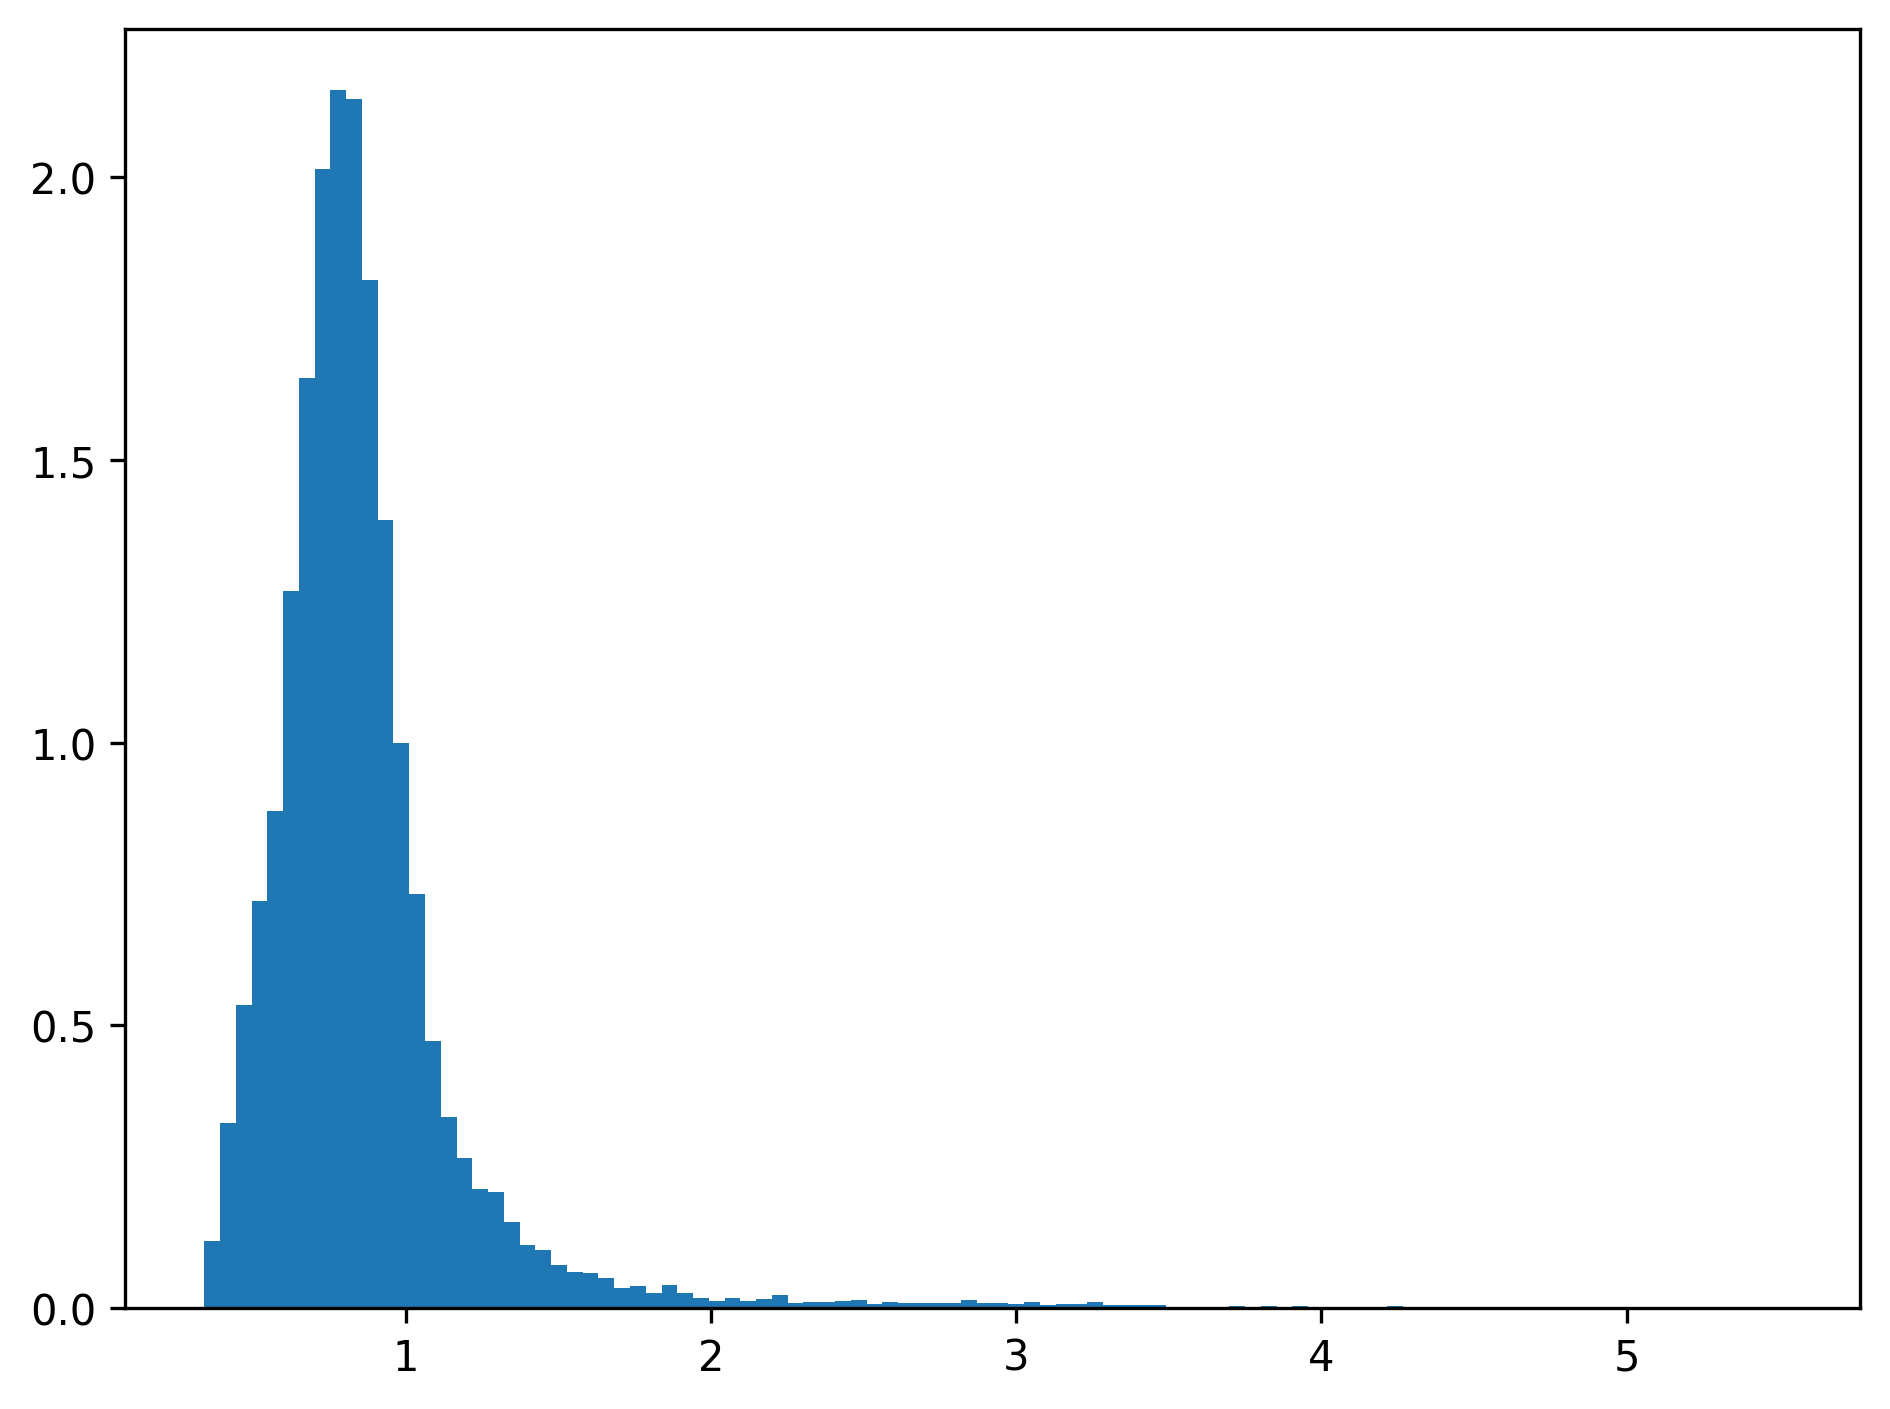

In [4]:
def pl_hist(df, column, n_bins=100,):
    data = df.select(pl.col(column))
    
    fig, ax = plt.subplots(1, 1, tight_layout=True)
    ax.hist(data, bins=n_bins, density=True)
    
    plt.show()
    plt.close()
    
pl_hist(exprData, "mean.cluster")

In [5]:
lfz = LegacyFuzzifier()

centers [0.4, 0.8, 1.2, 1.6, 2, 2.4]
Creating Universe Range 0.0 -> 8.0 with step size 0.1
Mean Expr mean.cluster col 7
Expr Count expr.cluster col 12
SD sd.cluster col 8
Cluster cluster col 0
Combining over state:  False


/mnt/raidbio/extproj/projekte/FlowSets/examples/../flowset.py:659: RuntimeWarning: invalid value encountered in divide
  values = fuzz.trimf(self.universe, abc)/unscaledValues


to_homogeneous: cluster.1
to_homogeneous: cluster.3
to_homogeneous: cluster.2


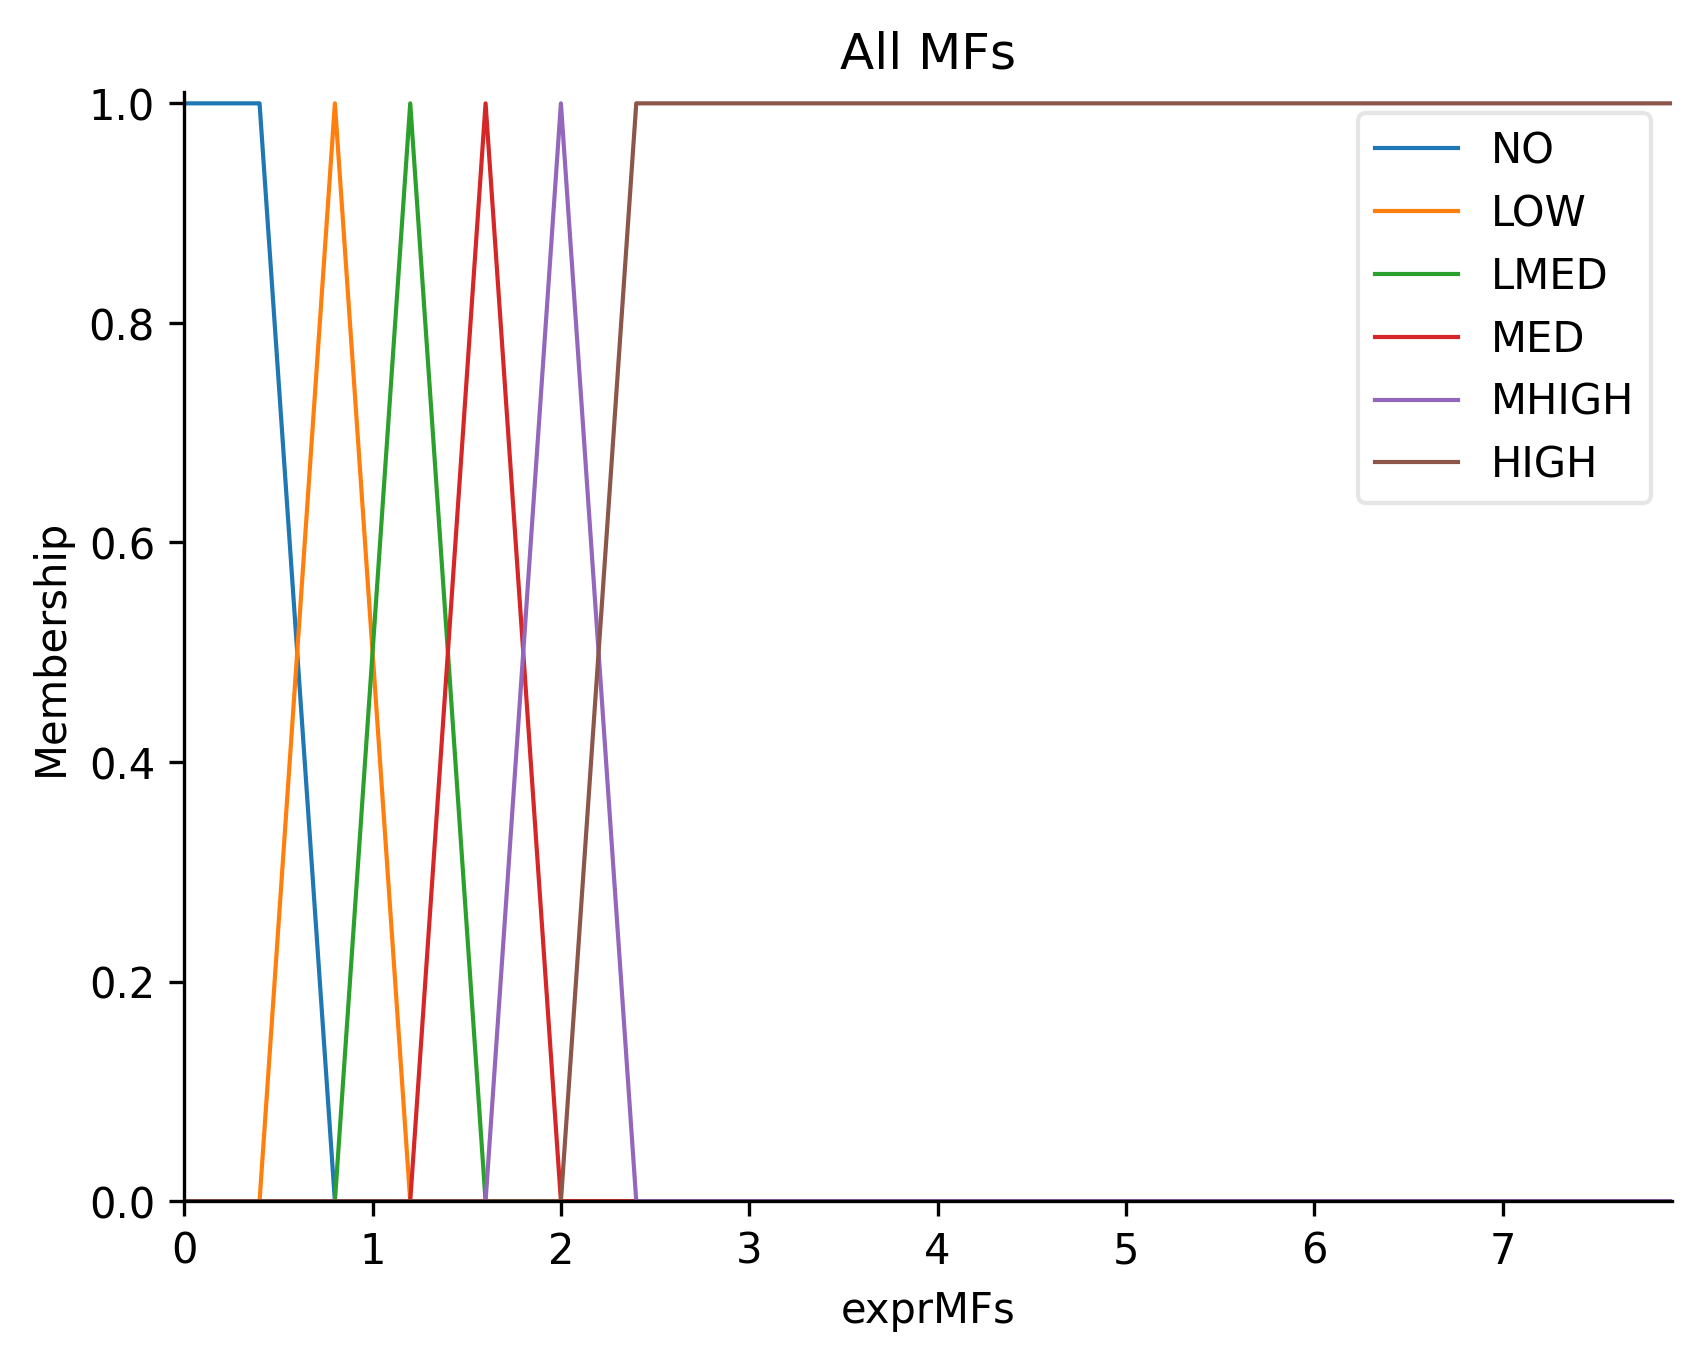

In [6]:
explDFWide, mfFuzzy = LegacyFuzzifier.fuzzify(exprData, stepsize=0.1, seriesOrder=["cluster.1","cluster.2","cluster.3"], mfLevels = ["NO","LOW","LMED","MED", "MHIGH", "HIGH"], centers=[0.4, 0.8, 1.2, 1.6, 2, 2.4]) #"cluster.thrombus"

In [7]:
isgListLong = sorted(set(["MX1","MX2","MT2A","RSAD2","SIGLEC1","IFIT1","IFI44","IFI27","IFITM10","IFIT3","IFI6","IFIT1P1","IFIT2","IFITM9P","IFI30","IFITM3","IFI44L","IFIT1B","IFITM5","IFITM3P2","IFITM3P9","IFI27L2","IFIT5","IFITM1","IFIH1","IFI16","IFI35","IFI27L1","IRF6","IRF7","IRF9","IRF5","IRF4","IRF2BP2","IRF2BPL","IRF3","IRF1-AS1","ISG15","ISG20L2","ISG20","XAF1","LY6E","IFITM2","IFITM3P6","IFITM3P3","IFIT6P","IRF2BP1","IRF5P1","IRF2","IRF1","IRF8","IFITM3P7","IFITM4P","IFITM3P1","IFITM3P8"]))
isgListShort = sorted(set(["MT2A", "ISG15", "LY6E", "IFIT1", "IFIT2", "IFIT3", "IFITM1", "IFITM3", "IFI44L", "IFI6", "MX1", "IFI27",  "IFI44L", "RSAD2", "SIGLEC1", "IFIT1"]))

In [8]:
fa = FlowAnalysis(explDFWide, "gene", (  ("1", "TP 1"),("2", "TP 2"),("3", "TP 3")), mfFuzzy, sep=".cluster.") #("thrombus", "Thrombus"),

In [9]:
import seaborn as sns

scm = fa._create_series_color_map(None, "scaling")
icefires = sns.color_palette("icefire", len(scm)+2)

sc = {x: scm[x](1.0) for xi, x in enumerate(scm)}
#sc = {x: icefires[xi+1] for xi, x in enumerate(scm)}
sc


{'TP 1': (0.267004, 0.004874, 0.329415, 1.0),
 'TP 2': (0.190631, 0.407061, 0.556089, 1.0),
 'TP 3': (0.20803, 0.718701, 0.472873, 1.0)}

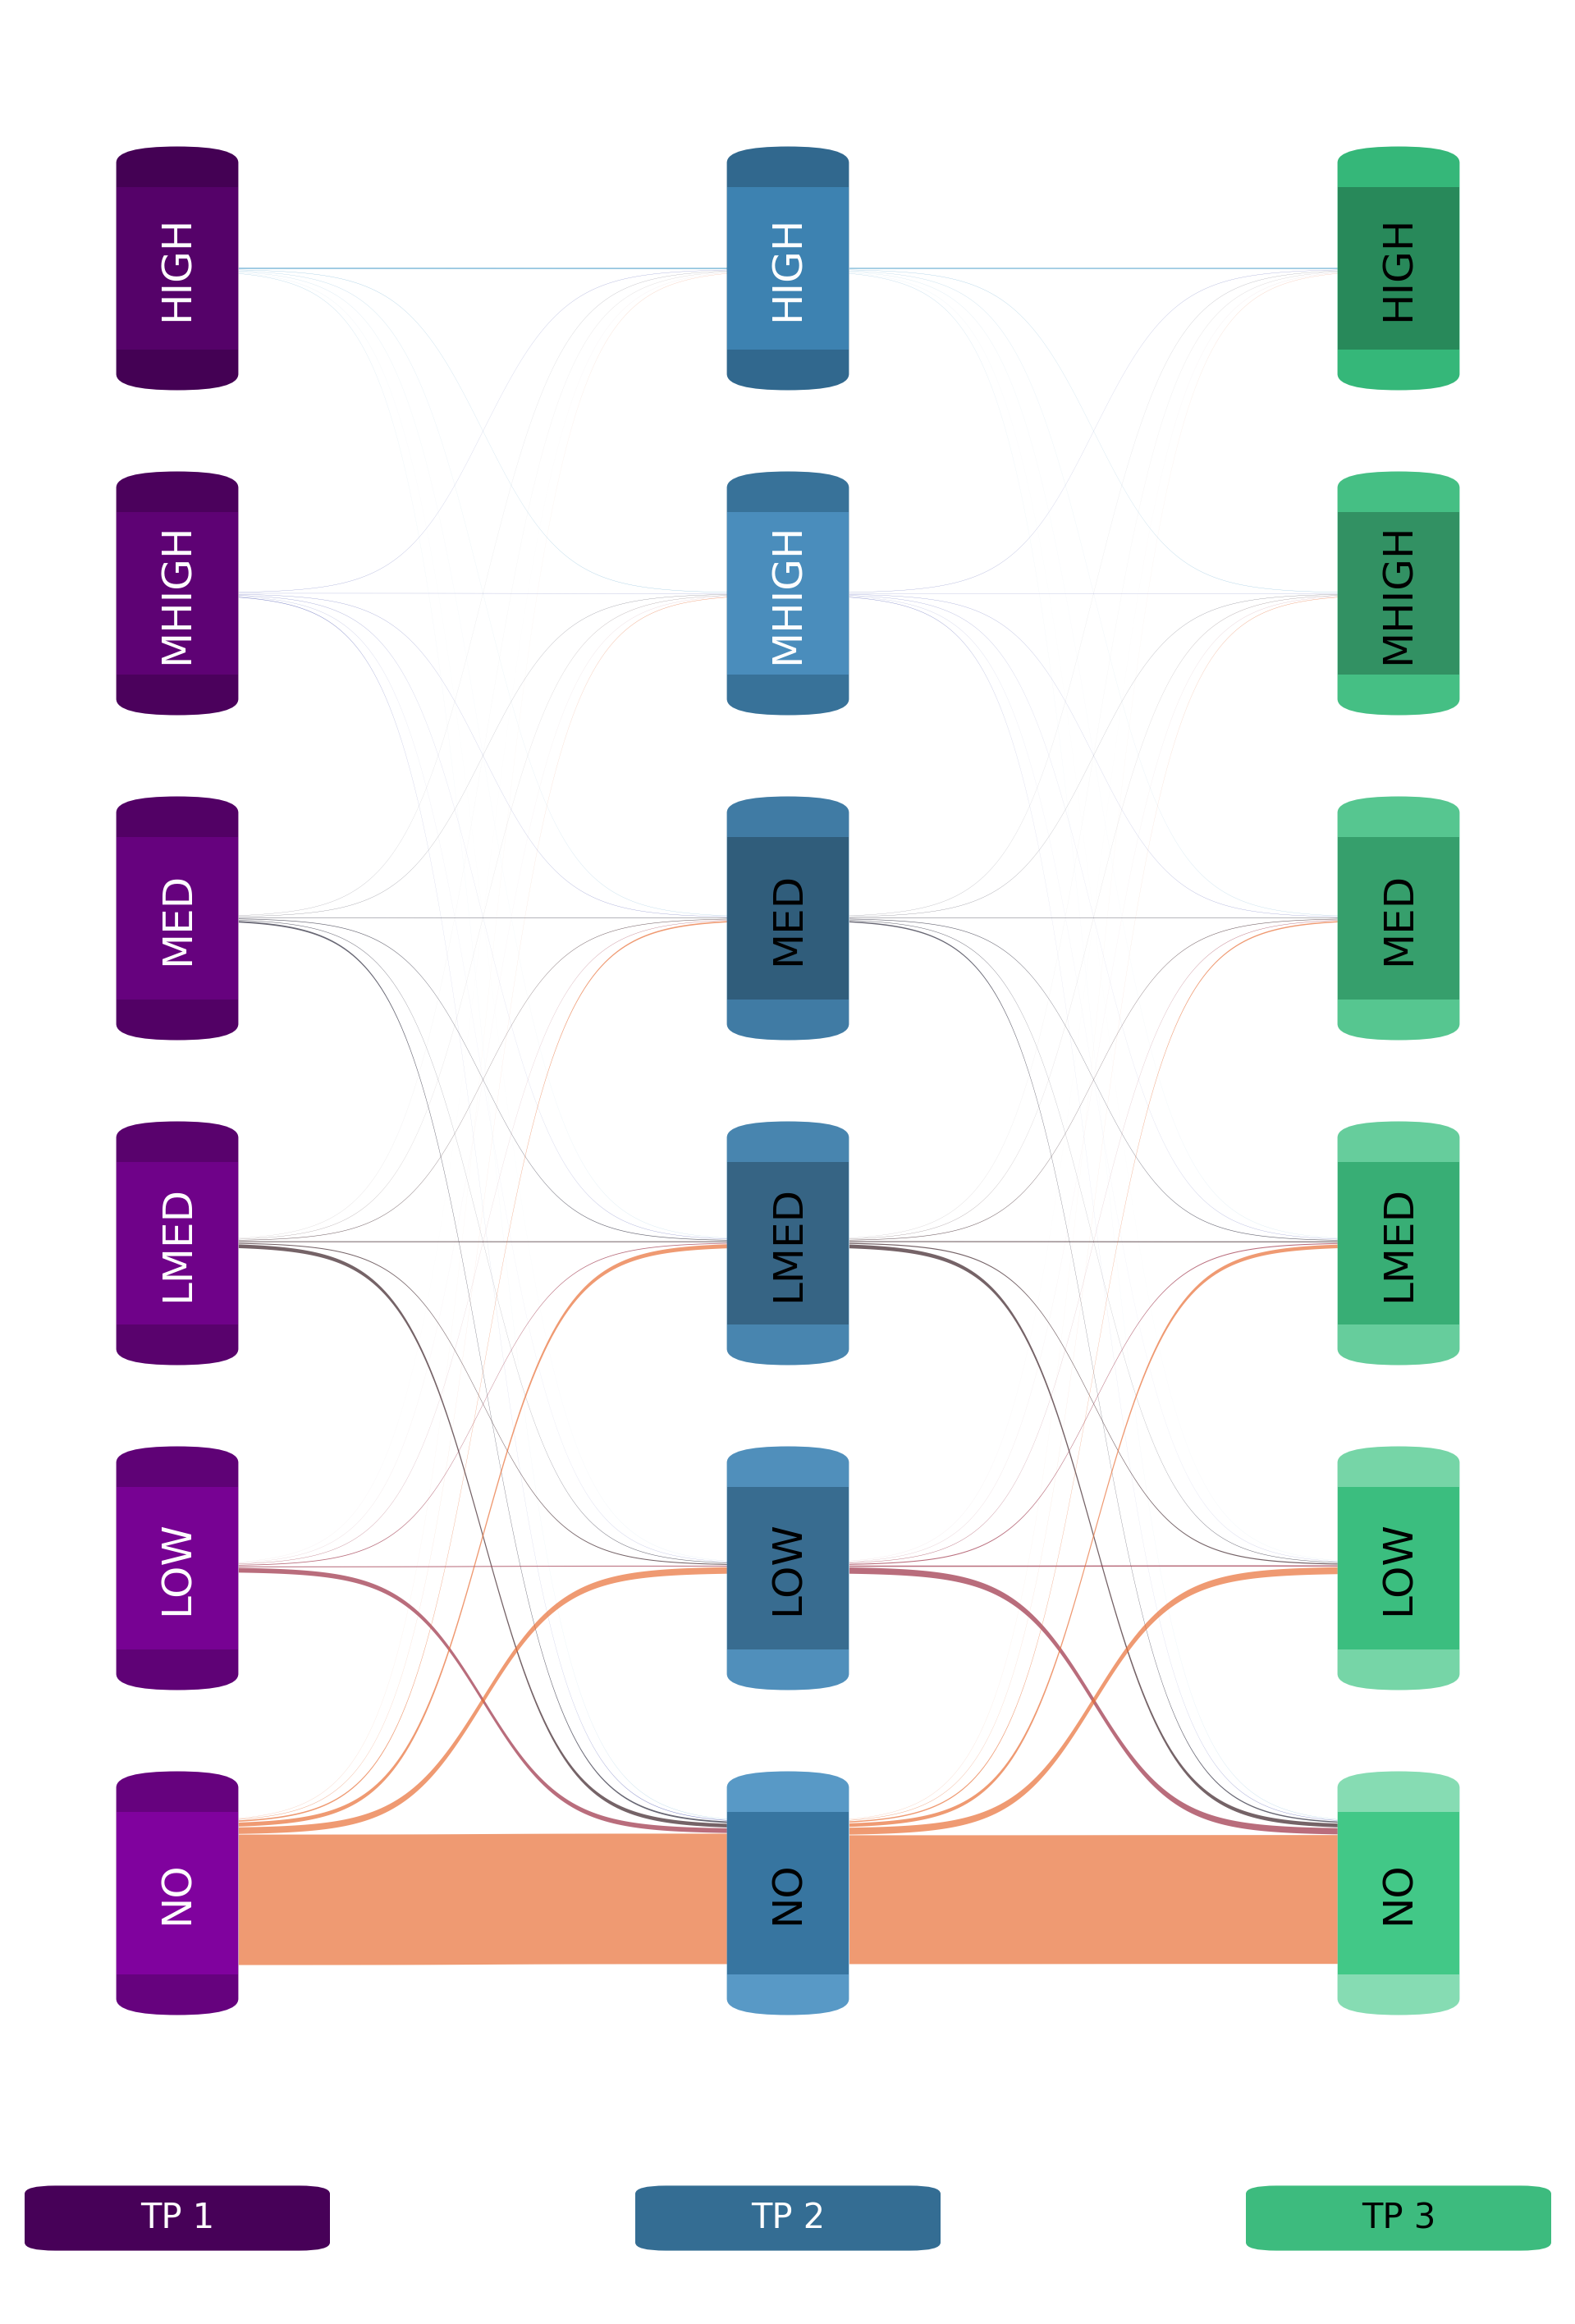

In [10]:
fa.plot_flows(verbose=False, seriesColors=sc, figsize=(8,12))

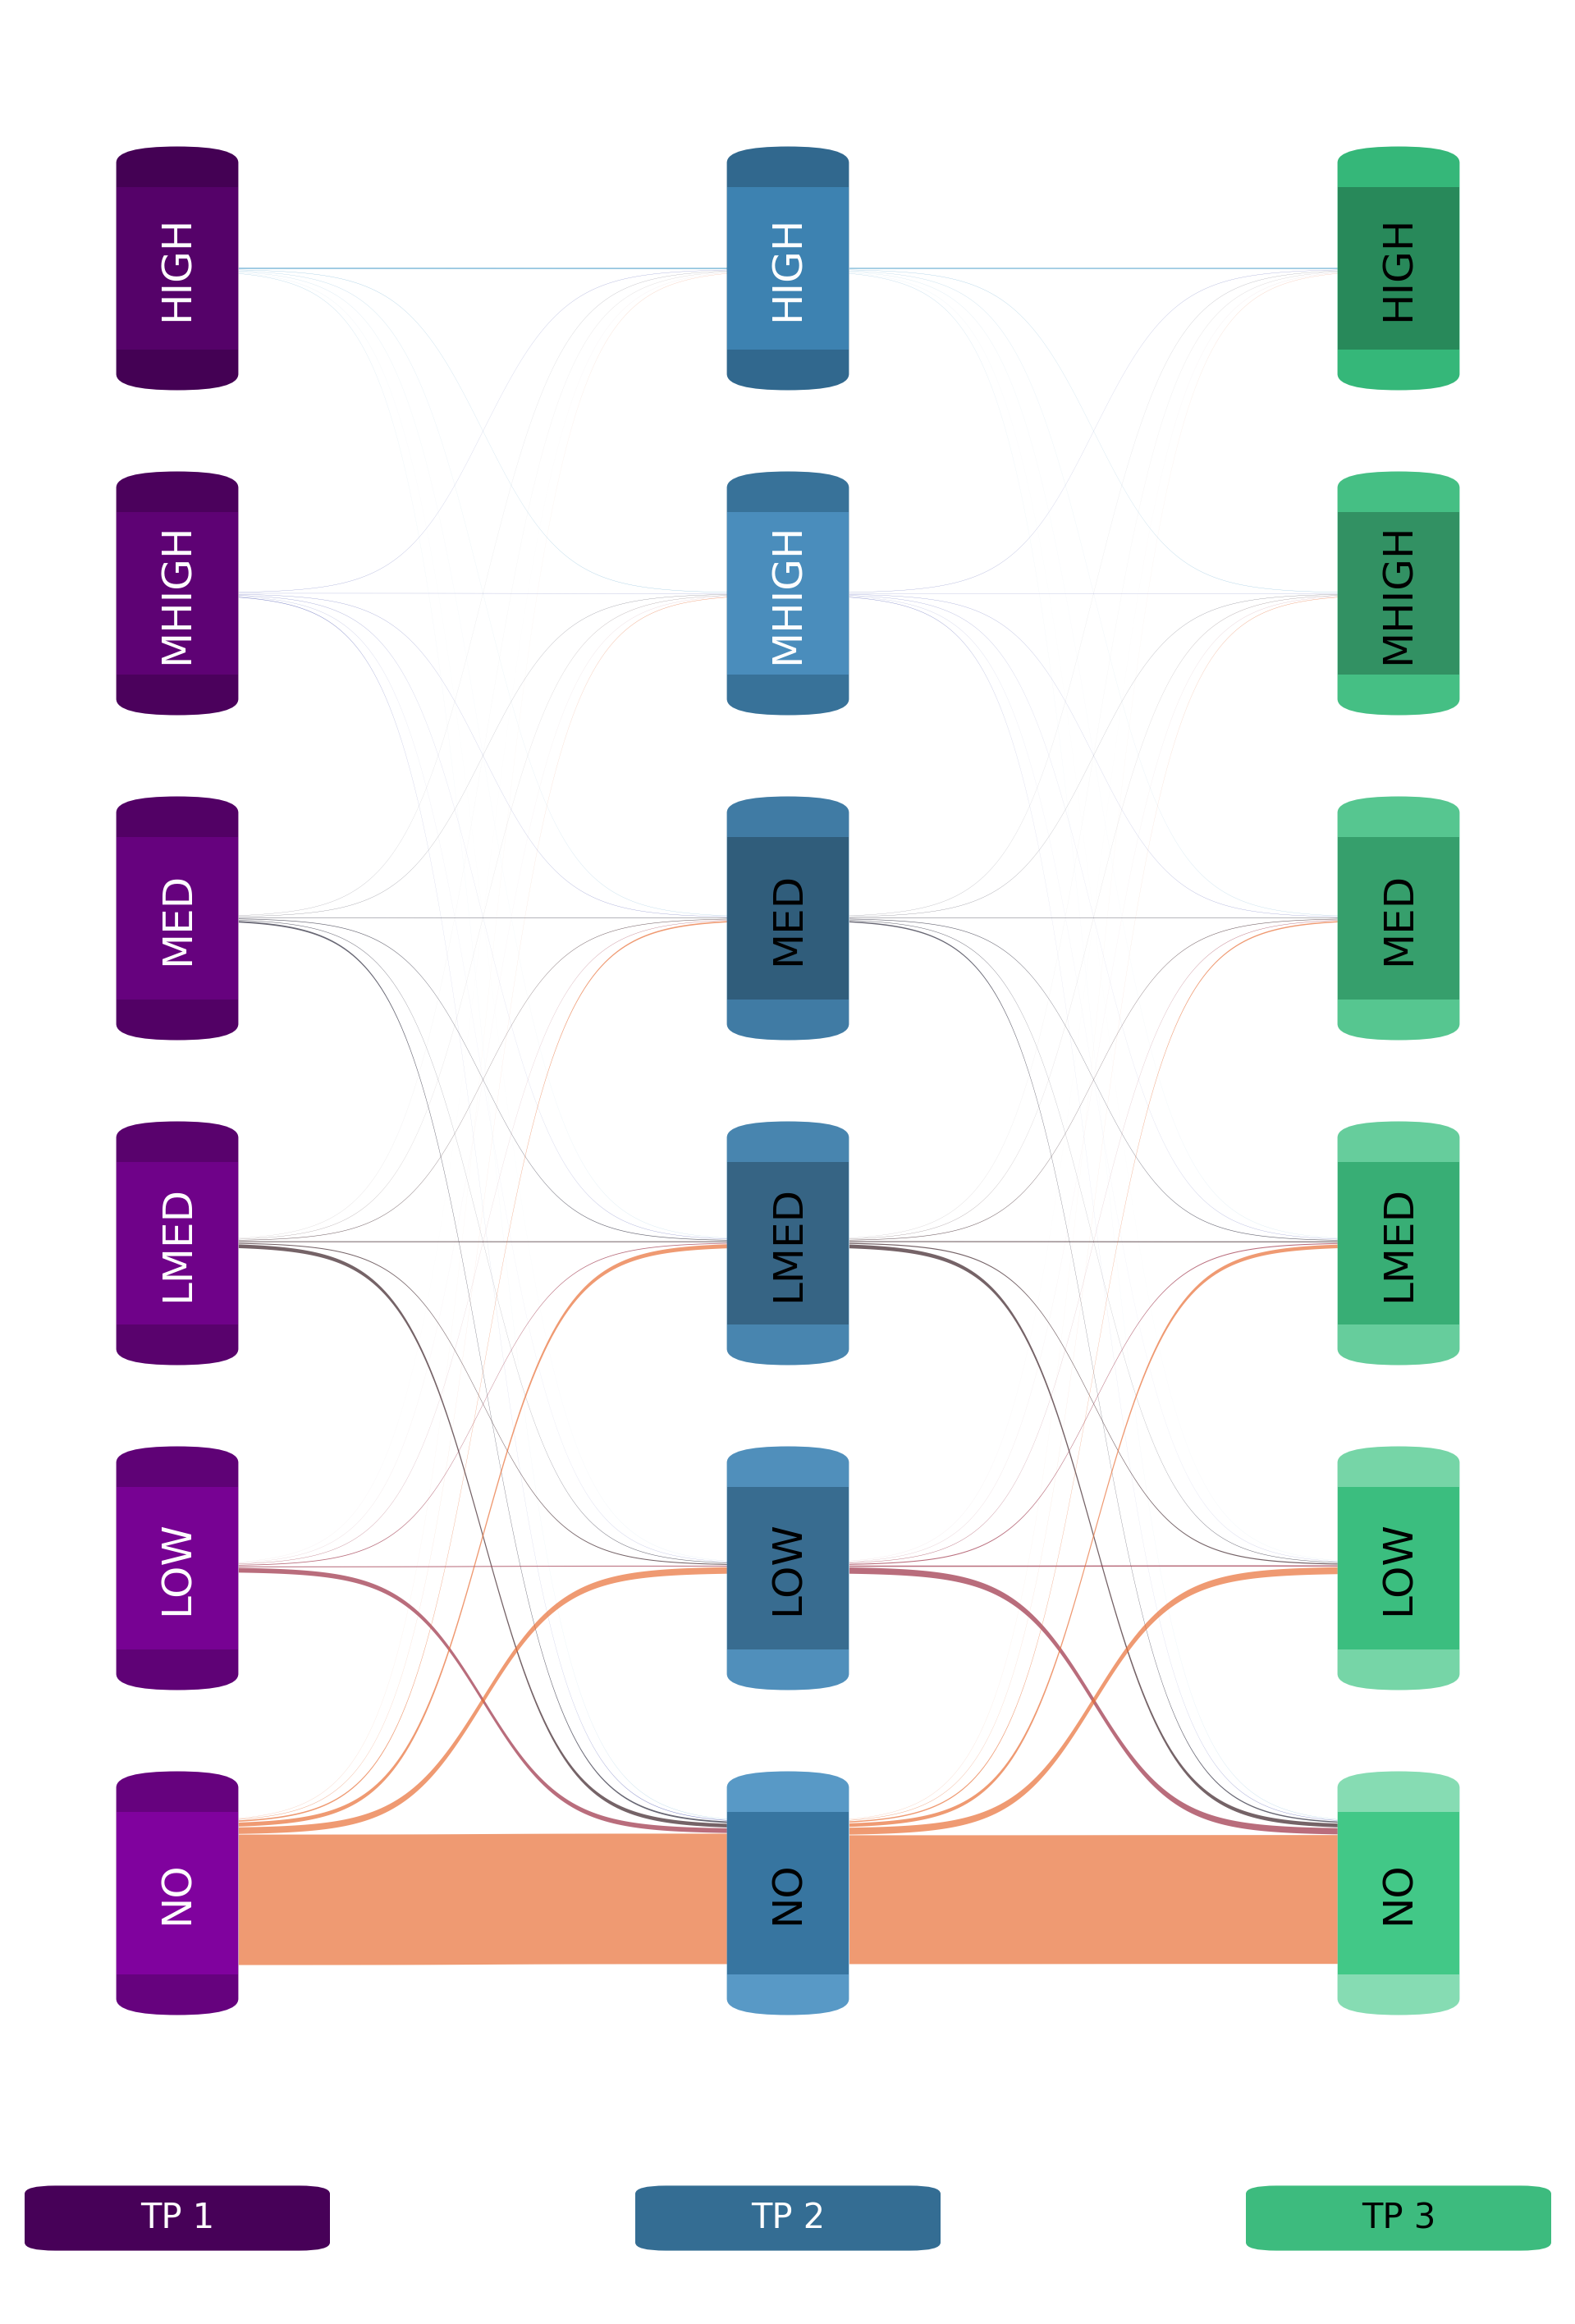

In [11]:
fa.plot_flows(outfile="plots/asympt_flows", seriesColors=sc, figsize=(8,12))

Creating FlowIDs
72 [('1', 'LMED'), ('2', 'NO'), ('3', 'NO')]
78 [('1', 'LMED'), ('2', 'LOW'), ('3', 'NO')]
79 [('1', 'LMED'), ('2', 'LOW'), ('3', 'LOW')]
108 [('1', 'MED'), ('2', 'NO'), ('3', 'NO')]
114 [('1', 'MED'), ('2', 'LOW'), ('3', 'NO')]
115 [('1', 'MED'), ('2', 'LOW'), ('3', 'LOW')]
120 [('1', 'MED'), ('2', 'LMED'), ('3', 'NO')]
121 [('1', 'MED'), ('2', 'LMED'), ('3', 'LOW')]
144 [('1', 'MHIGH'), ('2', 'NO'), ('3', 'NO')]
150 [('1', 'MHIGH'), ('2', 'LOW'), ('3', 'NO')]
151 [('1', 'MHIGH'), ('2', 'LOW'), ('3', 'LOW')]
156 [('1', 'MHIGH'), ('2', 'LMED'), ('3', 'NO')]
157 [('1', 'MHIGH'), ('2', 'LMED'), ('3', 'LOW')]
162 [('1', 'MHIGH'), ('2', 'MED'), ('3', 'NO')]
163 [('1', 'MHIGH'), ('2', 'MED'), ('3', 'LOW')]
180 [('1', 'HIGH'), ('2', 'NO'), ('3', 'NO')]
186 [('1', 'HIGH'), ('2', 'LOW'), ('3', 'NO')]
187 [('1', 'HIGH'), ('2', 'LOW'), ('3', 'LOW')]
192 [('1', 'HIGH'), ('2', 'LMED'), ('3', 'NO')]
193 [('1', 'HIGH'), ('2', 'LMED'), ('3', 'LOW')]
198 [('1', 'HIGH'), ('2', 'MED'), 

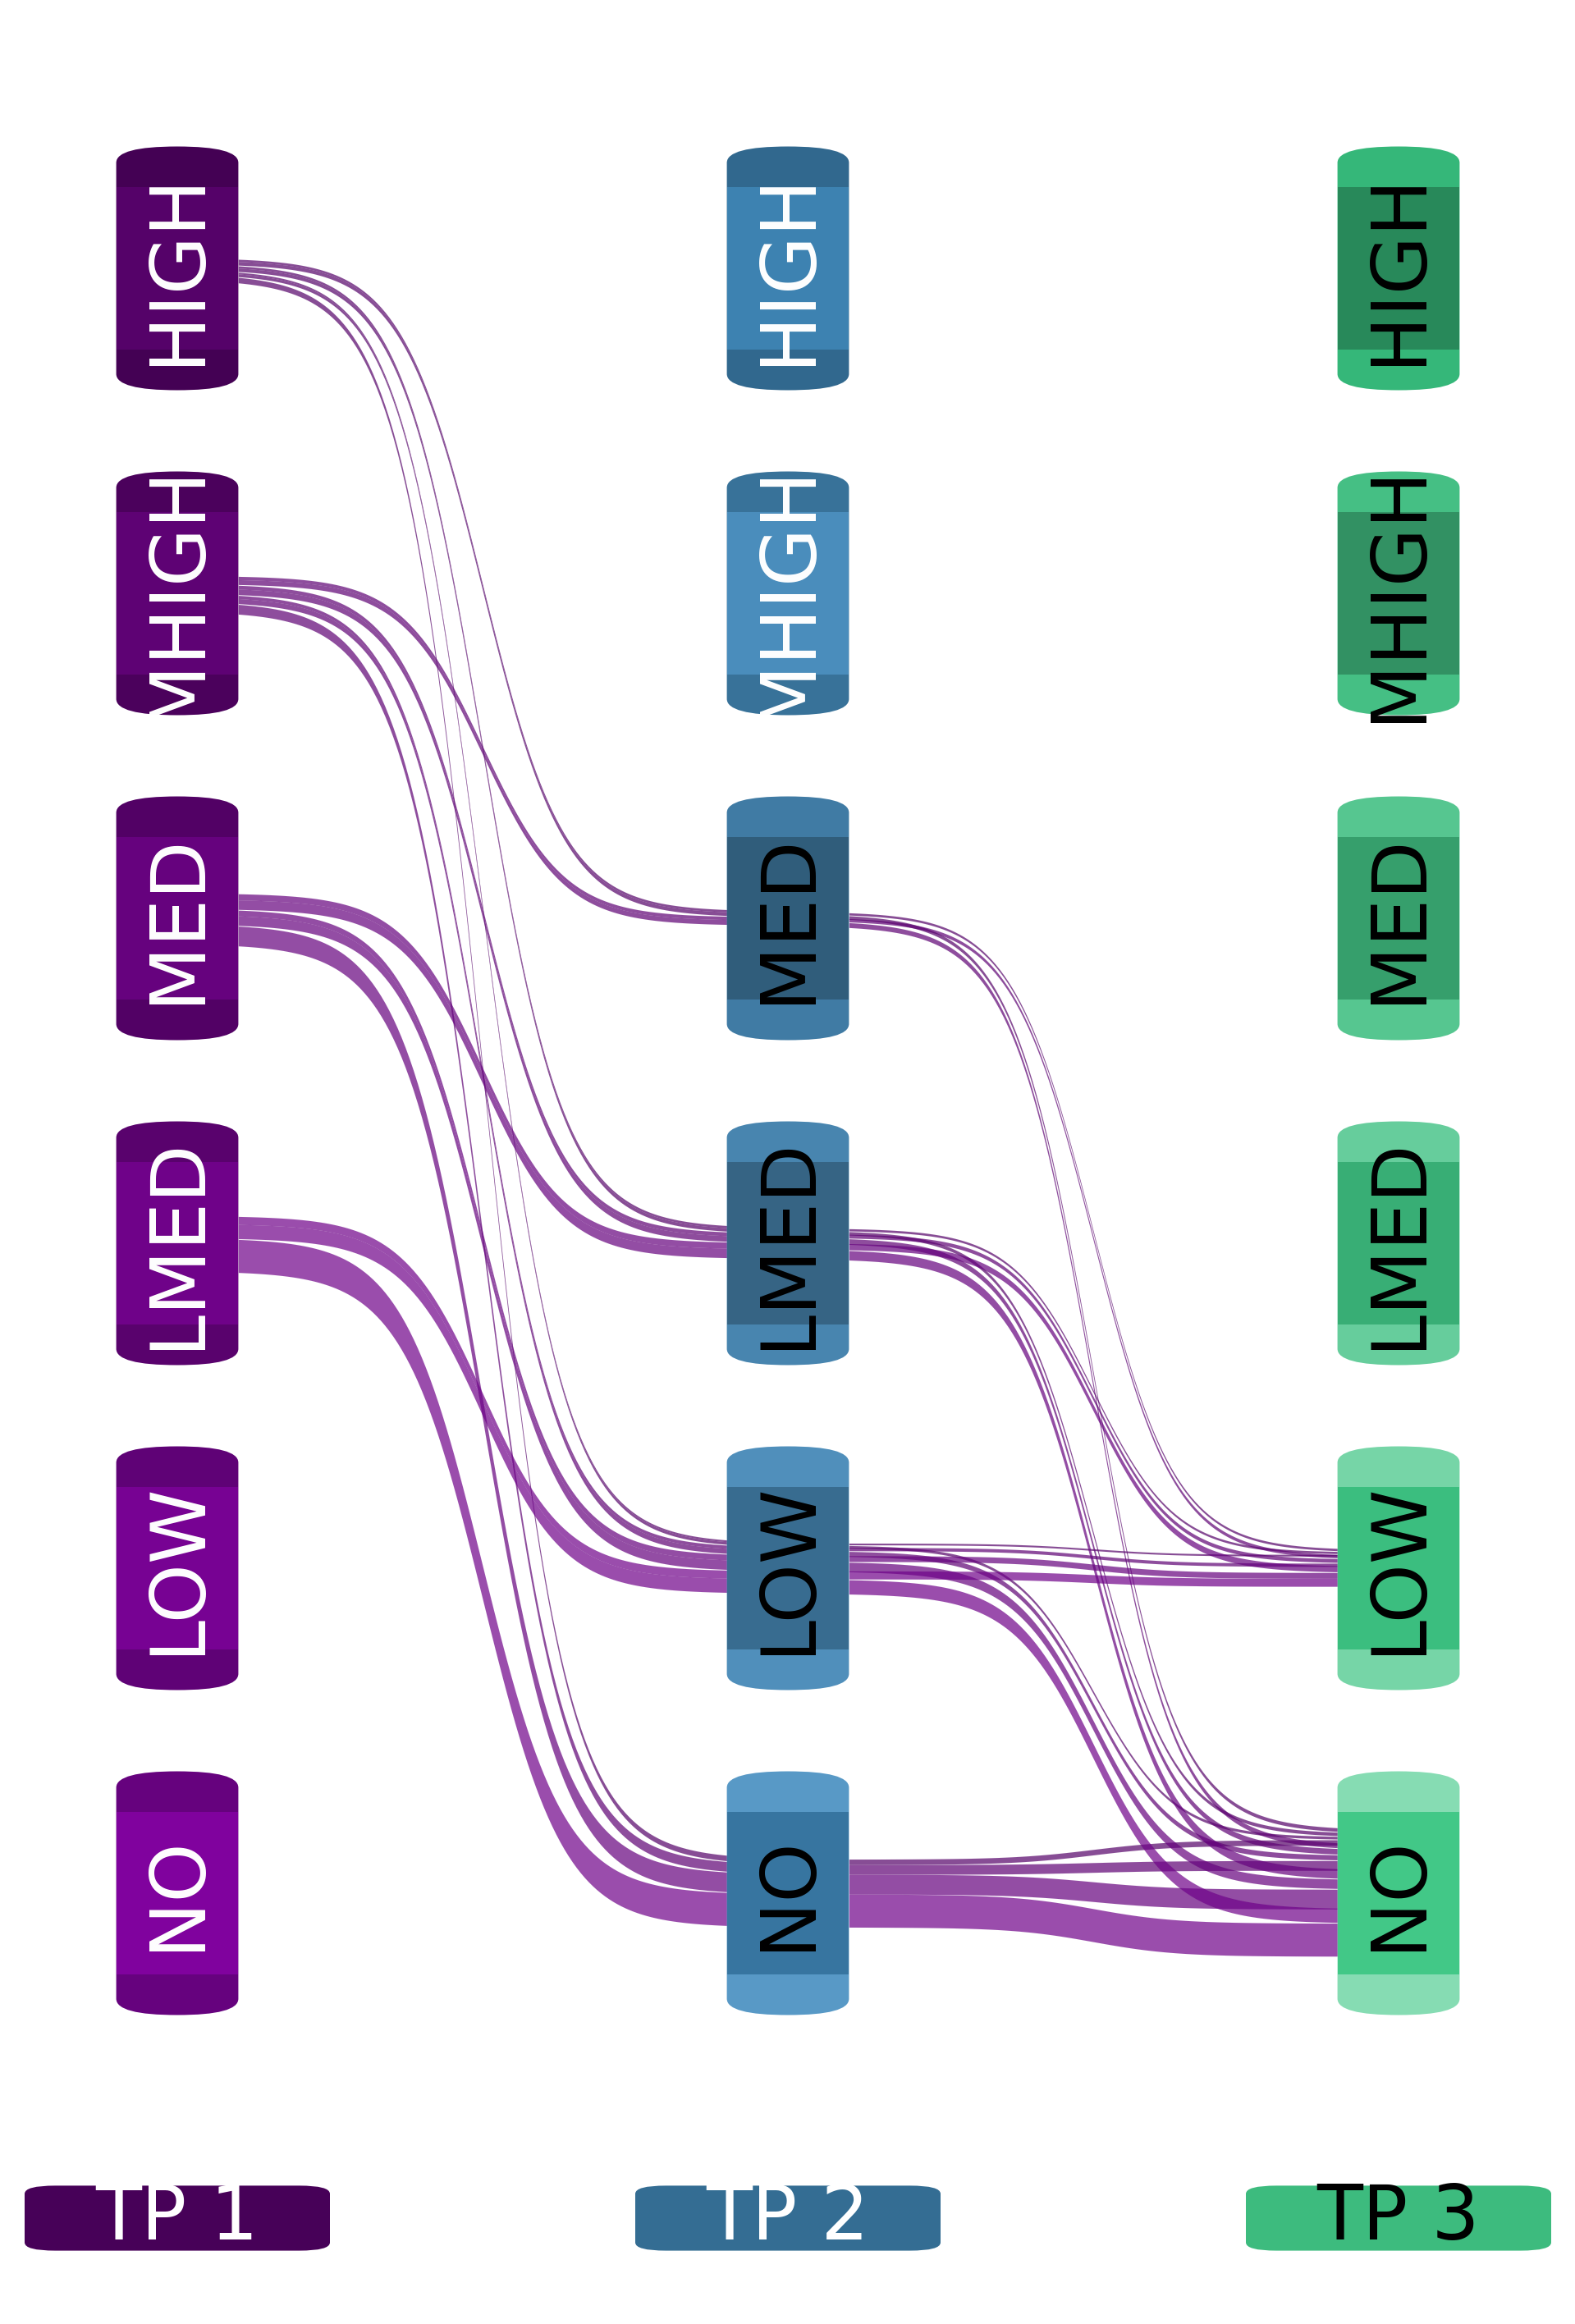

In [12]:
relFlows = fa.path_finder([">", ">="], minLevels=["LMED", None, None], maxLevels=["HIGH", "MED", "LOW"], verbose=True)

fa.plot_paths(use_flows=relFlows, seriesColors=sc, figsize=(8,12), outfile="plots/selected_paths")

In [13]:
# convert paths to edges

relEdges = fa.paths2edges(relFlows)

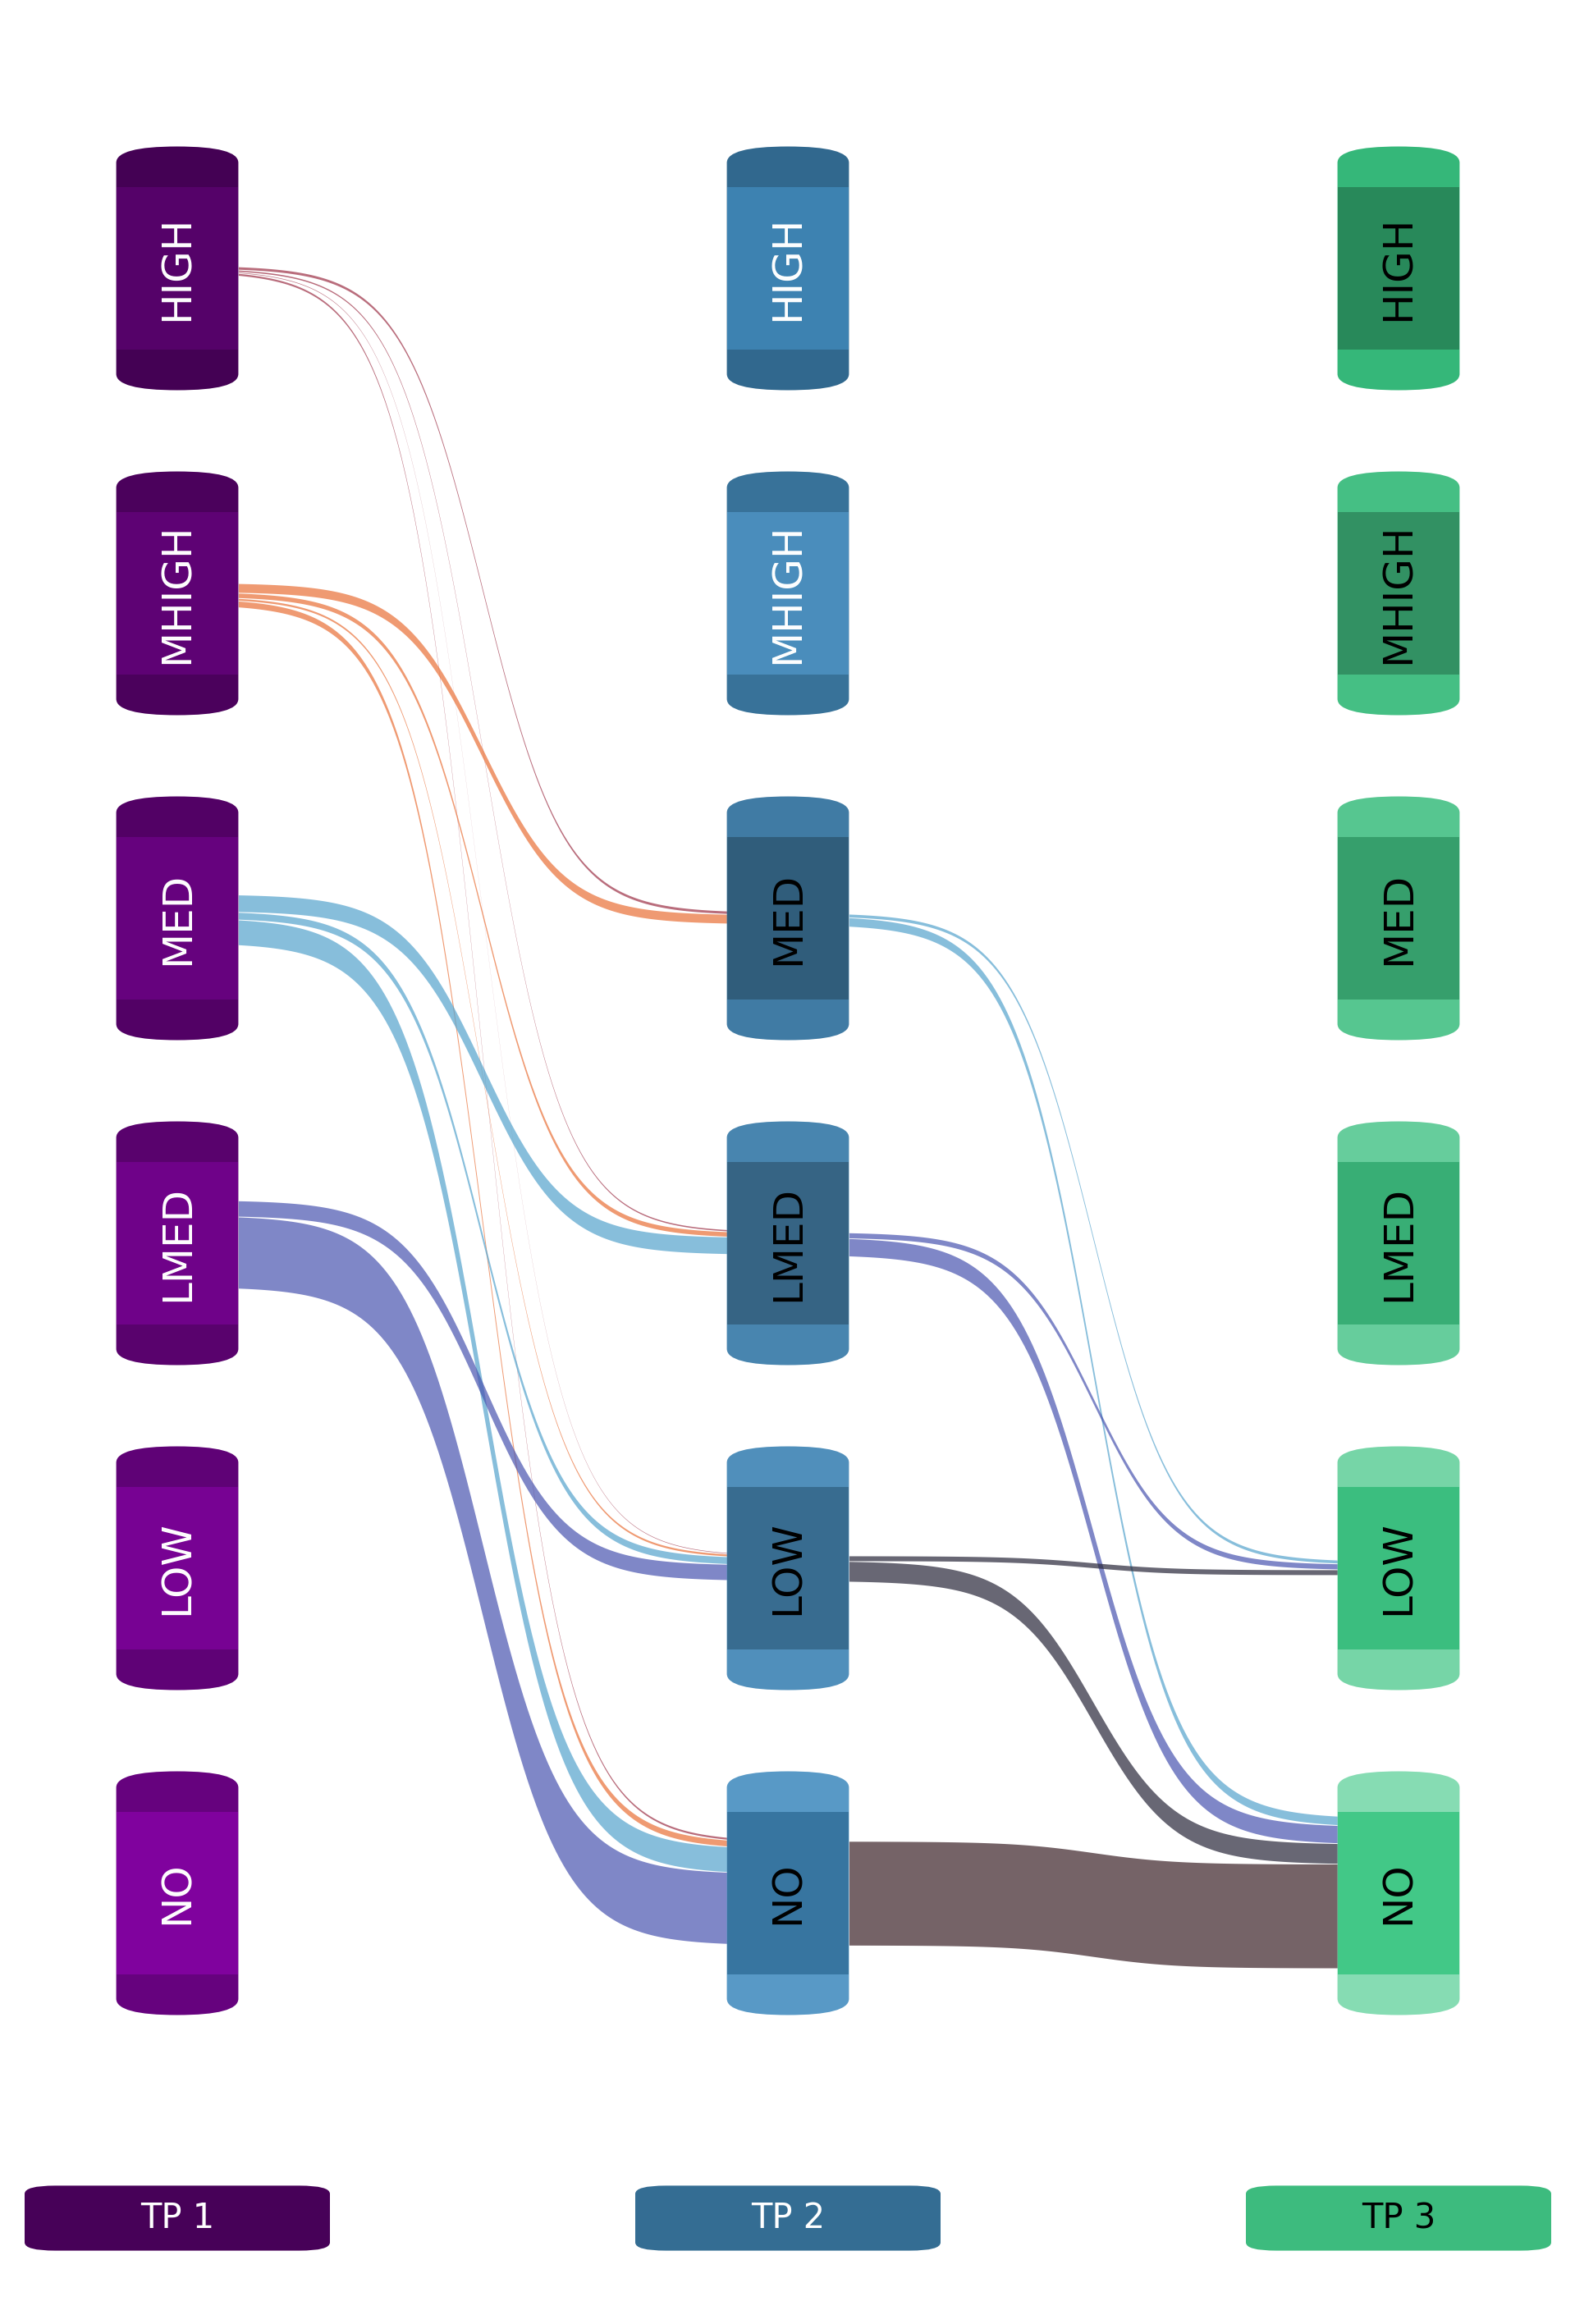

In [14]:
fa.plot_flows(relEdges, seriesColors=sc, figsize=(8,12), outfile="plots/selected_edges")

In [15]:
pwScoresGrp = fa.analyse_pathways(additional_genesets=[("ISG_SHORT", isgListShort), ("ISG_LONG", isgListLong)], use_edges=relEdges)
pwScoresGrp

Loading pathways from ReactomePathways.gmt
Identified 2612 pathways
Calculating p-values for groups [1, 2, 3, 4, 10, 50, 100, 2605]


pwid                                             pwname  \
14     R-HSA-112122      ALKBH2 mediated reversal of alkylation damage   
17    R-HSA-5467333  APC truncation mutants are not K63 polyubiquit...   
30    R-HSA-9717264                     ASP-3026-resistant ALK mutants   
46    R-HSA-2978092  Abnormal conversion of 2-oxoglutarate to 2-hyd...   
160    R-HSA-211957  Aromatic amines can be N-hydroxylated or N-dea...   
...             ...                                                ...   
2566    R-HSA-72172                                      mRNA Splicing   
2567    R-HSA-72163                      mRNA Splicing - Major Pathway   
2592    R-HSA-72312                                    rRNA processing   
2594  R-HSA-8868773         rRNA processing in the nucleus and cytosol   
2603    R-HSA-72306                                    tRNA processing   

         pwFlow  pwGenes   allPwFlow   allPwGenes  pw_gene_intersection  \
14     0.004436        1  552.295221  7670.000147                     1   
17     0.062387        1  552.295221  7670.000147                     1   
30     0.000000        1  552.295221  7670.000147                     0   
46     0.021394        1  552.295221  7670.000147                     1   
160    0.000000        1  552.295221  7670.000147                     0   
...         ...      ...         ...          ...                   ...   
2566  16.770866      215  552.295221  7670.000147                   209   
2567  16.459035      204  552.295221  7670.000147                   201   
2592   5.964936      237  552.295221  7670.000147                   210   
2594   5.706410      199  552.295221  7670.000147                   188   
2603   3.667840      146  552.295221  7670.000147                   119   

      pw_coverage  genes_coverage  mean_coverage  pw_coverage_zscore  \
14       0.004436        0.000008   3.563545e-08           -0.854503   
17       0.062387        0.000113   7.047248e-06            0.445630   
30       0.000000        0.000000   0.000000e+00           -0.954034   
46       0.021394        0.000039   8.287633e-07           -0.474047   
160      0.000000        0.000000   0.000000e+00           -0.954034   
...           ...             ...            ...                 ...   
2566     0.078004        0.030366   2.368652e-03            1.922469   
2567     0.080682        0.029801   2.404403e-03            2.071369   
2592     0.025169        0.010800   2.718266e-04           -1.015764   
2594     0.028675        0.010332   2.962795e-04           -0.820740   
2603     0.025122        0.006641   1.668386e-04           -1.018339   

      pw_coverage_pval  pw_coverage_adj_pval  
14            1.000000              1.000000  
17            0.327932              1.000000  
30            1.000000              1.000000  
46            1.000000              1.000000  
160           1.000000              1.000000  
...                ...                   ...  
2566          0.027273              0.887101  
2567          0.019162              0.887101  
2592          1.000000              1.000000  
2594          1.000000              1.000000  
2603          1.000000              1.000000  

[2614 rows x 13 columns]

pwid                                             pwname  \
2612      ISG_SHORT                                          ISG_SHORT   
418   R-HSA-3134963  DEx/H-box helicases activate type I IFN and in...   
2289  R-HSA-6791055  TALDO1 deficiency: failed conversion of SH7P, ...   
2288  R-HSA-6791462  TALDO1 deficiency: failed conversion of  Fru(6...   
2613       ISG_LONG                                           ISG_LONG   
848   R-HSA-2644605                 FBXW7 Mutants and NOTCH1 in Cancer   
1257  R-HSA-2644607  Loss of Function of FBXW7 in Cancer and NOTCH1...   
1876  R-HSA-9707587        Regulation of HMOX1 expression and activity   
899    R-HSA-163210          Formation of ATP by chemiosmotic coupling   
2040  R-HSA-3065676               SUMO is conjugated to E1 (UBA2:SAE1)   
1910   R-HSA-211733  Regulation of activated PAK-2p34 by proteasome...   
1964   R-HSA-163200  Respiratory electron transport, ATP synthesis ...   
1963   R-HSA-611105                     Respiratory electron transport   
105    R-HSA-114294  Activation, translocation and oligomerization ...   
397   R-HSA-1236978  Cross-presentation of soluble exogenous antige...   
2362   R-HSA-844456                             The NLRP3 inflammasome   
1880   R-HSA-877312                       Regulation of IFNG signaling   
468   R-HSA-9734195            Defective APRT disrupts adenine salvage   
2359   R-HSA-844615                              The AIM2 inflammasome   
1545  R-HSA-8983711                             OAS antiviral response   

         pwFlow  pwGenes   allPwFlow   allPwGenes  pw_gene_intersection  \
2612   4.496596       14  552.295221  7670.000147                    14   
418    1.139983        7  552.295221  7670.000147                     7   
2289   0.226180        1  552.295221  7670.000147                     1   
2288   0.226180        1  552.295221  7670.000147                     1   
2613   7.936149       55  552.295221  7670.000147                    40   
848    0.648656        5  552.295221  7670.000147                     5   
1257   0.648656        5  552.295221  7670.000147                     5   
1876   0.656011        5  552.295221  7670.000147                     5   
899    2.079586       18  552.295221  7670.000147                    18   
2040   0.667614        5  552.295221  7670.000147                     5   
1910   5.572906       50  552.295221  7670.000147                    48   
1964  12.380303      127  552.295221  7670.000147                   124   
1963  10.080375      103  552.295221  7670.000147                   103   
105    0.347507        2  552.295221  7670.000147                     2   
397    5.535951       50  552.295221  7670.000147                    45   
2362   1.775595       17  552.295221  7670.000147                    16   
1880   1.467598       14  552.295221  7670.000147                    14   
468    0.163844        1  552.295221  7670.000147                     1   
2359   0.420290        3  552.295221  7670.000147                     3   
1545   1.155732       10  552.295221  7670.000147                     8   

      pw_coverage  genes_coverage  mean_coverage  pw_coverage_zscore  \
2612     0.321185        0.008142       0.002615           11.941989   
418      0.162855        0.002064       0.000336            4.288487   
2289     0.226180        0.000410       0.000093            4.120338   
2288     0.226180        0.000410       0.000093            4.120338   
2613     0.144294        0.014369       0.002073            3.151540   
848      0.129731        0.001174       0.000152            3.143728   
1257     0.129731        0.001174       0.000152            3.143728   
1876     0.131202        0.001188       0.000156            3.194572   
899      0.115533        0.003765       0.000435            3.174890   
2040     0.133523        0.001209       0.000161            3.274768   
1910     0.111458        0.010090       0.001125            3.001195   
1964     0.097483   

Index(['pwid', 'pwname', 'pwFlow', 'pwGenes', 'allPwFlow', 'allPwGenes',
       'pw_gene_intersection', 'pw_coverage', 'genes_coverage',
       'mean_coverage', 'pw_coverage_zscore', 'pw_coverage_pval',
       'pw_coverage_adj_pval'],
      dtype='object')
False
False
(10, 14)


/mnt/raidbio/extproj/projekte/FlowSets/examples/../flowset.py:2848: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


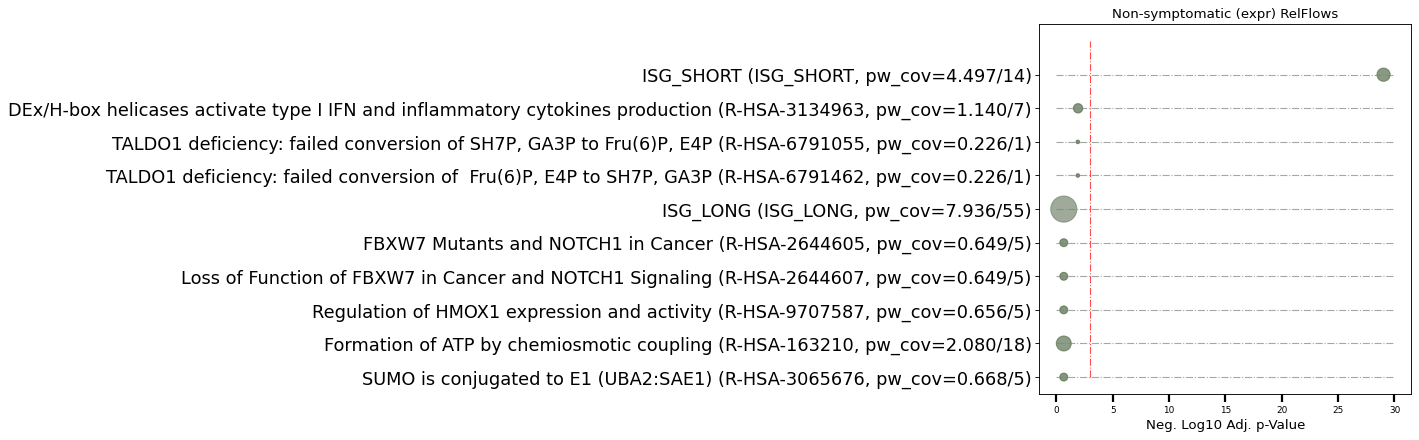

In [16]:
selPWsGrp = pwScoresGrp[(pwScoresGrp["pw_coverage_adj_pval"] < 1)].sort_values("pw_coverage_adj_pval", ascending=True).head(20)
display(selPWsGrp)
fa.plotORAresult(selPWsGrp, "Non-symptomatic (expr) RelFlows", numResults=10, figsize=(6,6), outfile="plots/asympt_ra")

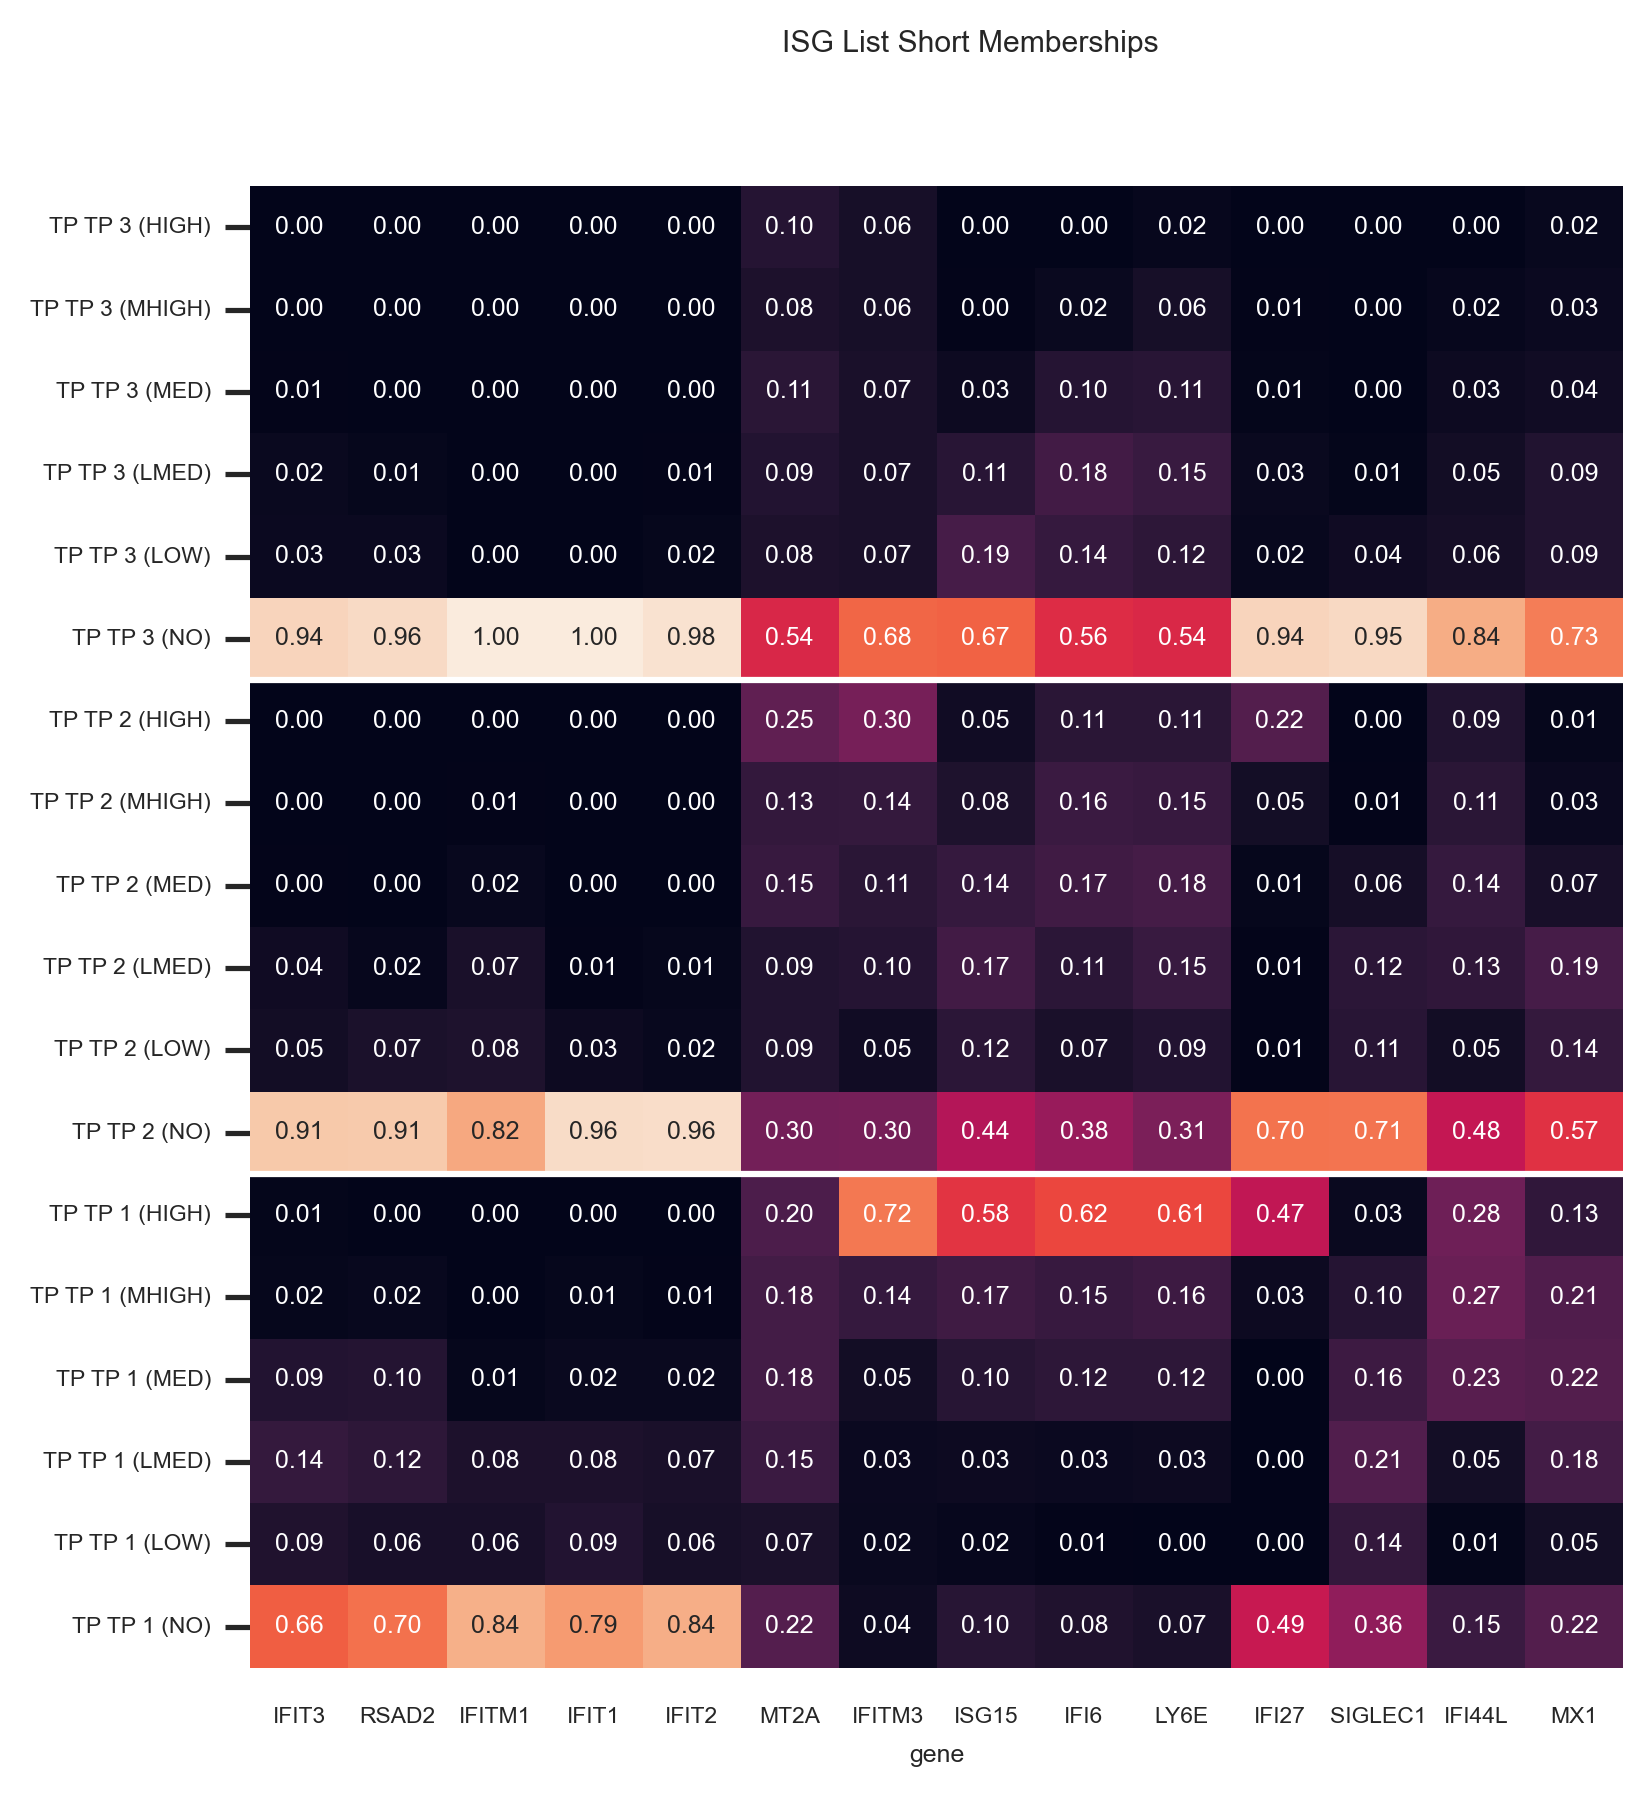

In [17]:
_=fa.plot_state_memberships(genes=isgListShort, name="ISG List Short Memberships", cluster_genes=True, outfile="plots/asympt_memberships", prefix="TP", font_scale=0.5)

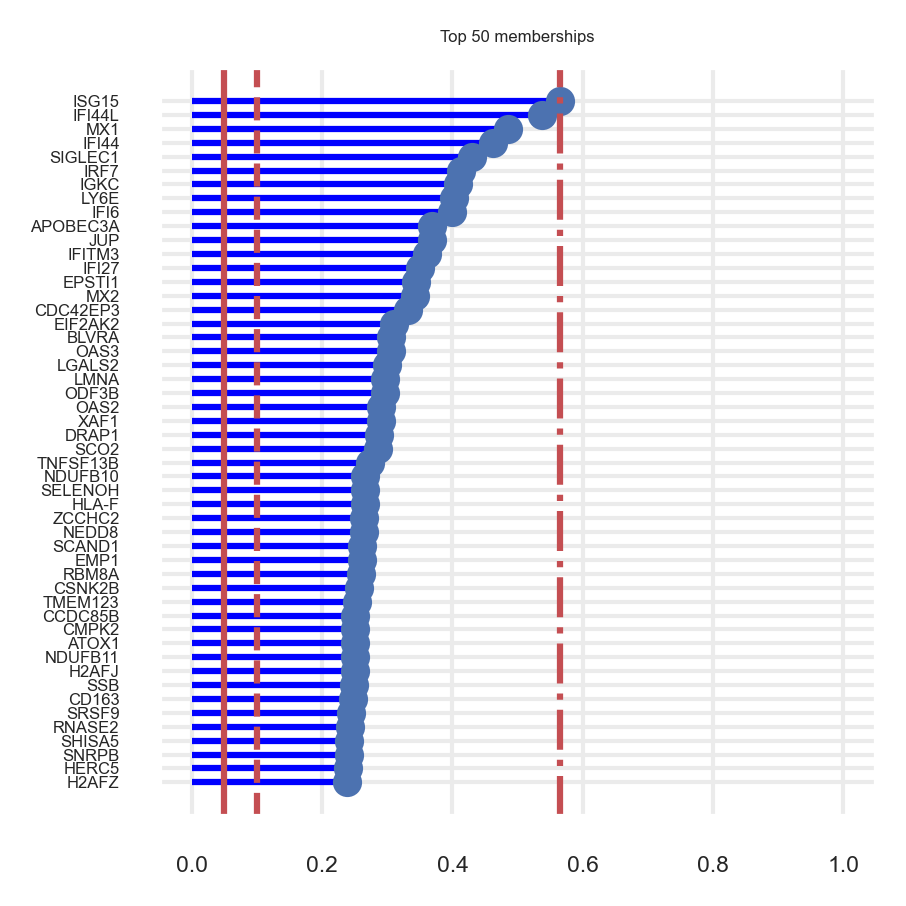

In [18]:
_=fa.plot_flow_memberships(use_edges=relEdges, outfile="plots/asympt_flow_memberships", n_genes=50, gene_exclude_patterns=["AC", "AF", "AL", "LINC"], figsize=(3,3), plot_histogram=False)

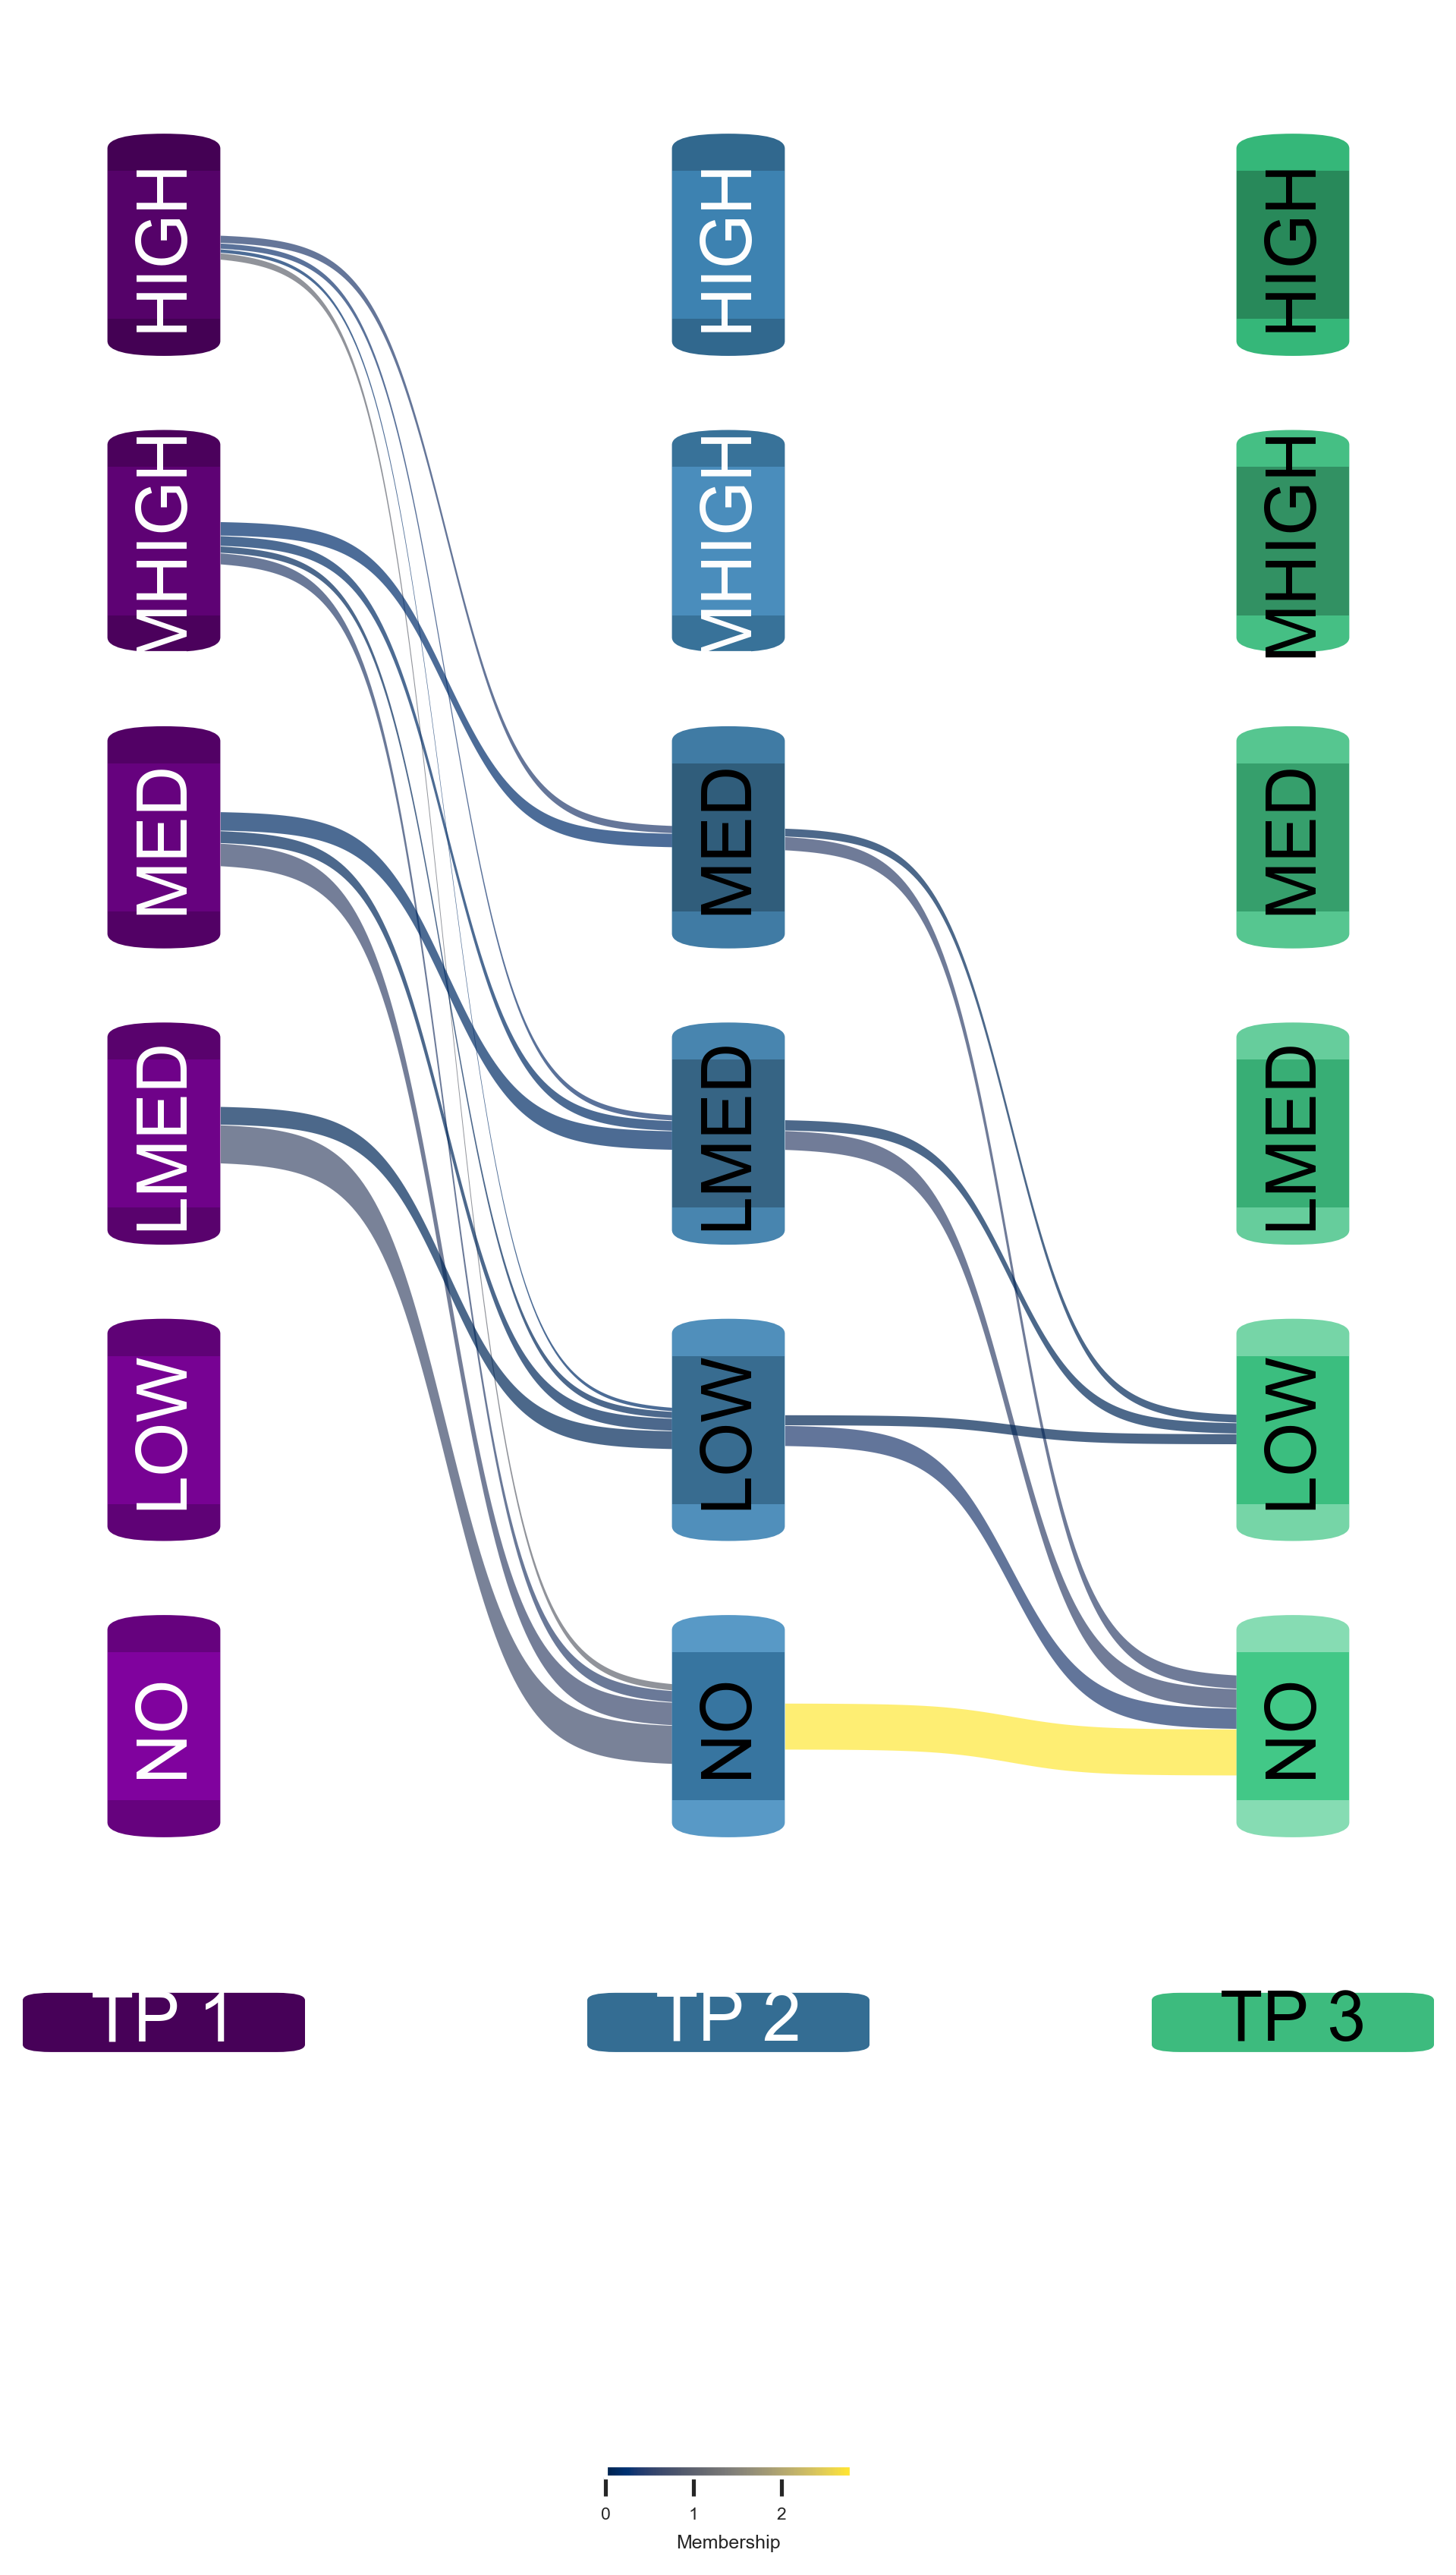

In [19]:
_=fa.visualize_genes(genes=isgListShort, use_edges=relEdges, outfile="plots/asympt_isg_flow", figsize=(8,14), seriesColors=sc)

In [20]:
pwScoresGrpGO = fa.analyse_pathways(genesets_file="go_human.bp.gmt", additional_genesets=[("ISG_SHORT", isgListShort), ("ISG_LONG", isgListLong)], use_edges=relEdges)
pwScoresGrpGO

Loading pathways from go_human.bp.gmt
Identified 12535 pathways
Calculating p-values for groups [1, 2, 3, 4, 10, 50, 100, 1226]


pwid                                             pwname    pwFlow  \
7     GO:0010789  meiotic sister chromatid cohesion involved in ...  0.000000   
20    GO:1900101  regulation of endoplasmic reticulum unfolded p...  0.014293   
25    GO:0043610             regulation of carbohydrate utilization  0.000000   
28    GO:0072522    purine-containing compound biosynthetic process  0.000000   
53    GO:0043416  regulation of skeletal muscle tissue regeneration  0.000000   
...          ...                                                ...       ...   
1774  GO:0010976  positive regulation of neuron projection devel...  3.514906   
1860  GO:0001822                                 kidney development  2.518000   
1861  GO:0007568                                              aging  5.176613   
1881  GO:0018108                  peptidyl-tyrosine phosphorylation  4.698241   
2493  GO:0006457                                    protein folding  7.512775   

      pwGenes   allPwFlow    allPwGenes  pw_gene_intersection  pw_coverage  \
7           1  552.295221  11415.000213                     1     0.000000   
20          1  552.295221  11415.000213                     1     0.014293   
25          1  552.295221  11415.000213                     0     0.000000   
28          1  552.295221  11415.000213                     0     0.000000   
53          1  552.295221  11415.000213                     0     0.000000   
...       ...         ...           ...                   ...          ...   
1774      111  552.295221  11415.000213                    73     0.031666   
1860      115  552.295221  11415.000213                    64     0.021896   
1861      146  552.295221  11415.000213                   102     0.035456   
1881      139  552.295221  11415.000213                    99     0.033800   
2493      156  552.295221  11415.000213                   123     0.048159   

      genes_coverage  mean_coverage  pw_coverage_zscore  pw_coverage_pval  \
7           0.000000   0.000000e+00           -0.995238          1.000000   
20          0.000026   3.698853e-07           -0.749952          1.000000   
25          0.000000   0.000000e+00           -0.995238          1.000000   
28          0.000000   0.000000e+00           -0.995238          1.000000   
53          0.000000   0.000000e+00           -0.995238          1.000000   
...              ...            ...                 ...               ...   
1774        0.006364   2.015270e-04           -0.210992          1.000000   
1860        0.004559   9.982568e-05           -0.907952          1.000000   
1861        0.009373   3.323283e-04            0.059401          0.476316   
1881        0.008507   2.875309e-04           -0.058728          1.000000   
2493        0.013603   6.550959e-04            0.965544          0.167136   

      pw_coverage_adj_pval  
7                      1.0  
20                     1.0  
25                     1.0  
28                     1.0  
53                     1.0  
...                    ...  
1774                   1.0  
1860                   1.0  
1861                   1.0  
1881                   1.0  
2493                   1.0  

[12537 rows x 13 columns]

pwid                                             pwname  \
12535   ISG_SHORT                                          ISG_SHORT   
5175   GO:0070106          interleukin-27-mediated signaling pathway   
5995   GO:0032020                          ISG15-protein conjugation   
2460   GO:0035456                        response to interferon-beta   
7070   GO:0035455                       response to interferon-alpha   
12536    ISG_LONG                                           ISG_LONG   
4936   GO:0034340                      response to type I interferon   
397    GO:0045071    negative regulation of viral genome replication   
7189   GO:0036261             7-methylguanosine cap hypermethylation   
988    GO:0042776  proton motive force-driven mitochondrial ATP s...   
987    GO:0009060                                aerobic respiration   
8673   GO:0019941   modification-dependent protein catabolic process   
396    GO:0009615                                  response to virus   
842    GO:0034134             toll-like receptor 2 signaling pathway   
3296   GO:1903241                    U2-type prespliceosome assembly   
5173   GO:0060339  negative regulation of type I interferon-media...   
1267   GO:0070585              protein localization to mitochondrion   
2239   GO:0006122  mitochondrial electron transport, ubiquinol to...   
4845   GO:0120183  positive regulation of focal adhesion disassembly   
732    GO:0006120  mitochondrial electron transport, NADH to ubiq...   

         pwFlow  pwGenes   allPwFlow    allPwGenes  pw_gene_intersection  \
12535  4.496596       14  552.295221  11415.000213                    14   
5175   1.560444        7  552.295221  11415.000213                     7   
5995   1.206685        6  552.295221  11415.000213                     6   
2460   1.876189       11  552.295221  11415.000213                    10   
7070   1.817793       11  552.295221  11415.000213                     9   
12536  7.936149       55  552.295221  11415.000213                    40   
4936   1.569166        9  552.295221  11415.000213                     9   
397    6.008664       44  552.295221  11415.000213                    39   
7189   1.208634        8  552.295221  11415.000213                     8   
988    7.340272       64  552.295221  11415.000213                    63   
987    6.961470       66  552.295221  11415.000213                    66   
8673   1.191593        9  552.295221  11415.000213                     8   
396    9.693705      109  552.295221  11415.000213                    88   
842    0.762210        6  552.295221  11415.000213                     6   
3296   2.648874       24  552.295221  11415.000213                    24   
5173   2.070809       19  552.295221  11415.000213                    16   
1267   1.167722       11  552.295221  11415.000213                     8   
2239   1.457060       14  552.295221  11415.000213                    13   
4845   0.711918        6  552.295221  11415.000213                     6   
732    4.730818       46  552.295221  11415.000213                    45   

       pw_coverage  genes_coverage  mean_coverage  pw_coverage_zscore  \
12535     0.321185        0.008142       0.002615           13.987537   
5175      0.222921        0.002825       0.000630            7.502581   
5995      0.201114        0.002185       0.000439            6.630060   
2460      0.170563        0.003397       0.000579            6.607283   
7070      0.165254        0.003291       0.000544            6.347161   
12536     0.144294        0.014369       0.002073            6.296411   
4936      0.174352        0.002841       0.000495            5.559243   
397       0.136561        0.010879       0.001486            4.941238   
7189      0.151079        0.002188       0.000331            4.628062   
988       0.114692        0.013290       0.001524            4.579252   
987       0.105477        0.012605       0.001329            4.044708   
8673      0.132399        0

Index(['pwid', 'pwname', 'pwFlow', 'pwGenes', 'allPwFlow', 'allPwGenes',
       'pw_gene_intersection', 'pw_coverage', 'genes_coverage',
       'mean_coverage', 'pw_coverage_zscore', 'pw_coverage_pval',
       'pw_coverage_adj_pval'],
      dtype='object')
False
False
(20, 14)


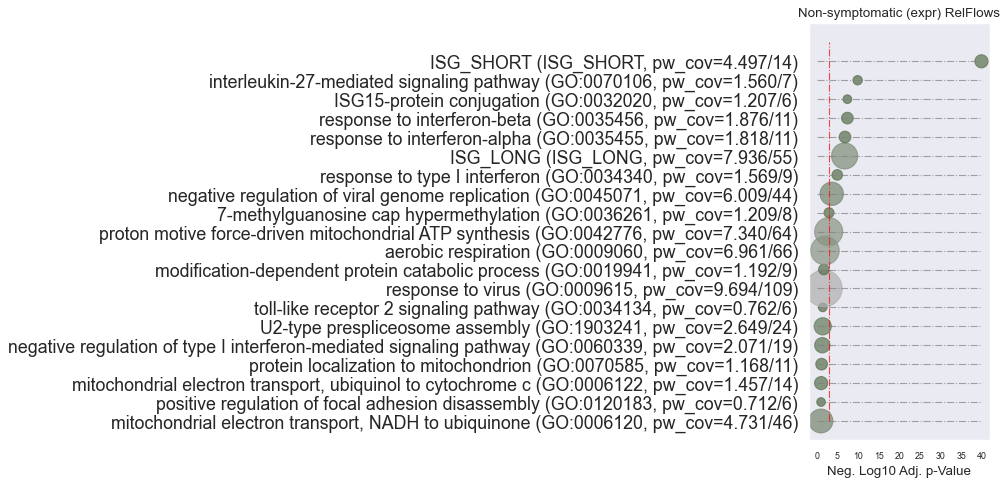

In [21]:
selPWsGrpGO = pwScoresGrpGO[(pwScoresGrpGO["pw_coverage_adj_pval"] < 1) & (pwScoresGrpGO["pwGenes"] > 5)].sort_values("pw_coverage_adj_pval", ascending=True).head(20)
display(selPWsGrpGO)
fa.plotORAresult(selPWsGrpGO, "Non-symptomatic (expr) RelFlows", numResults=20, figsize=(6,6), outfile="plots/asympt_go")

In [22]:
go=fa.get_pathways("go_human.bp.gmt")

Loading pathways from go_human.bp.gmt
Identified 12535 pathways


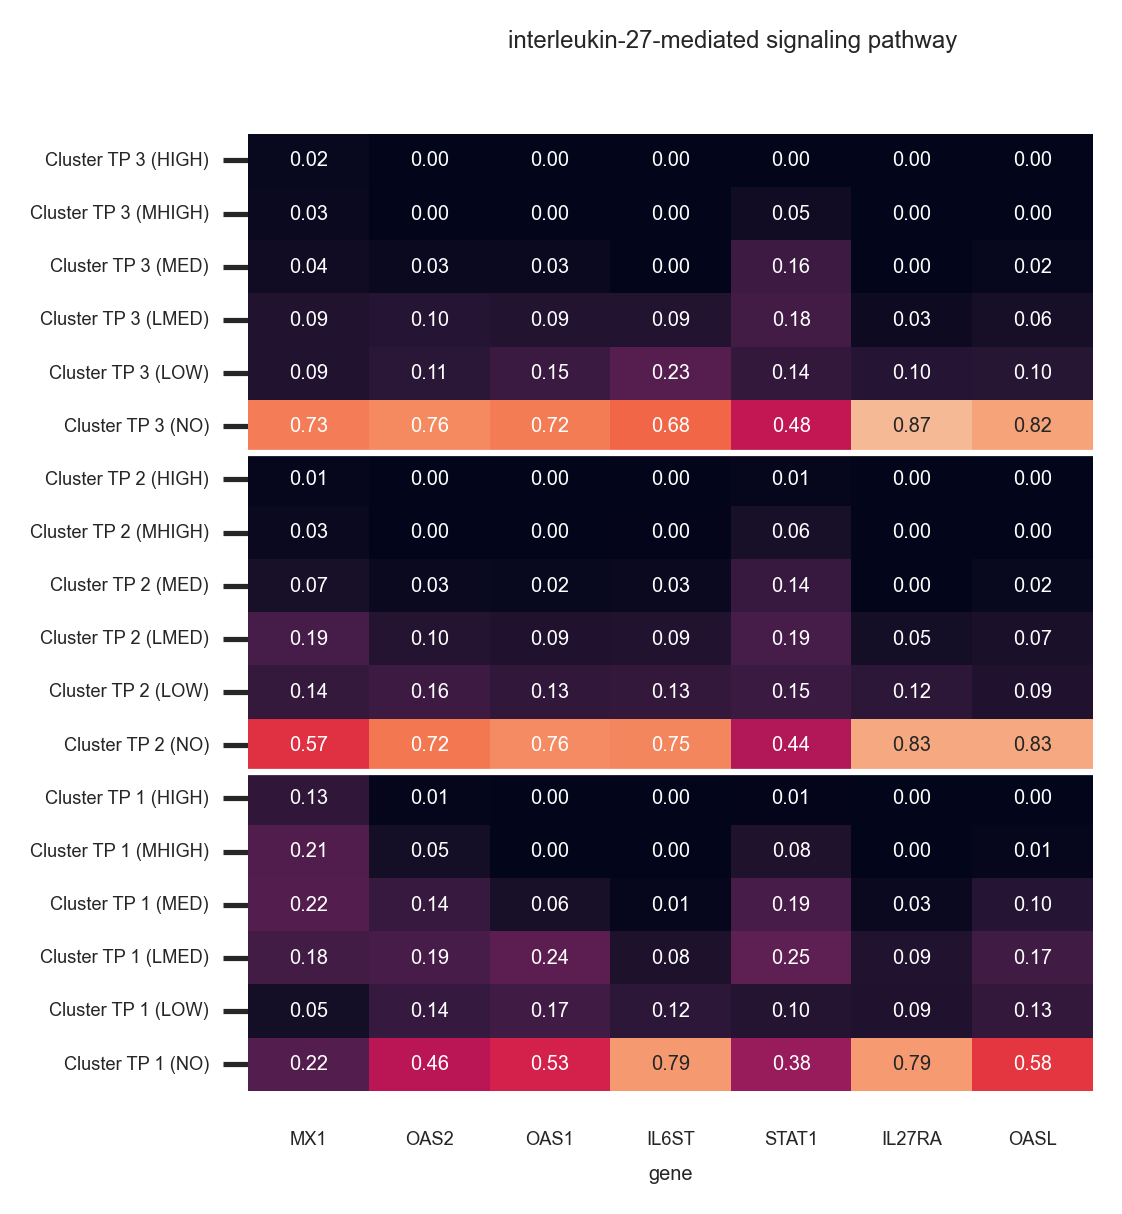

In [23]:
_=fa.plot_state_memberships(go["GO:0070106"][1], name=go["GO:0070106"][0], figsize=(4,4), outfile="plots/GO_0070106_memberships")

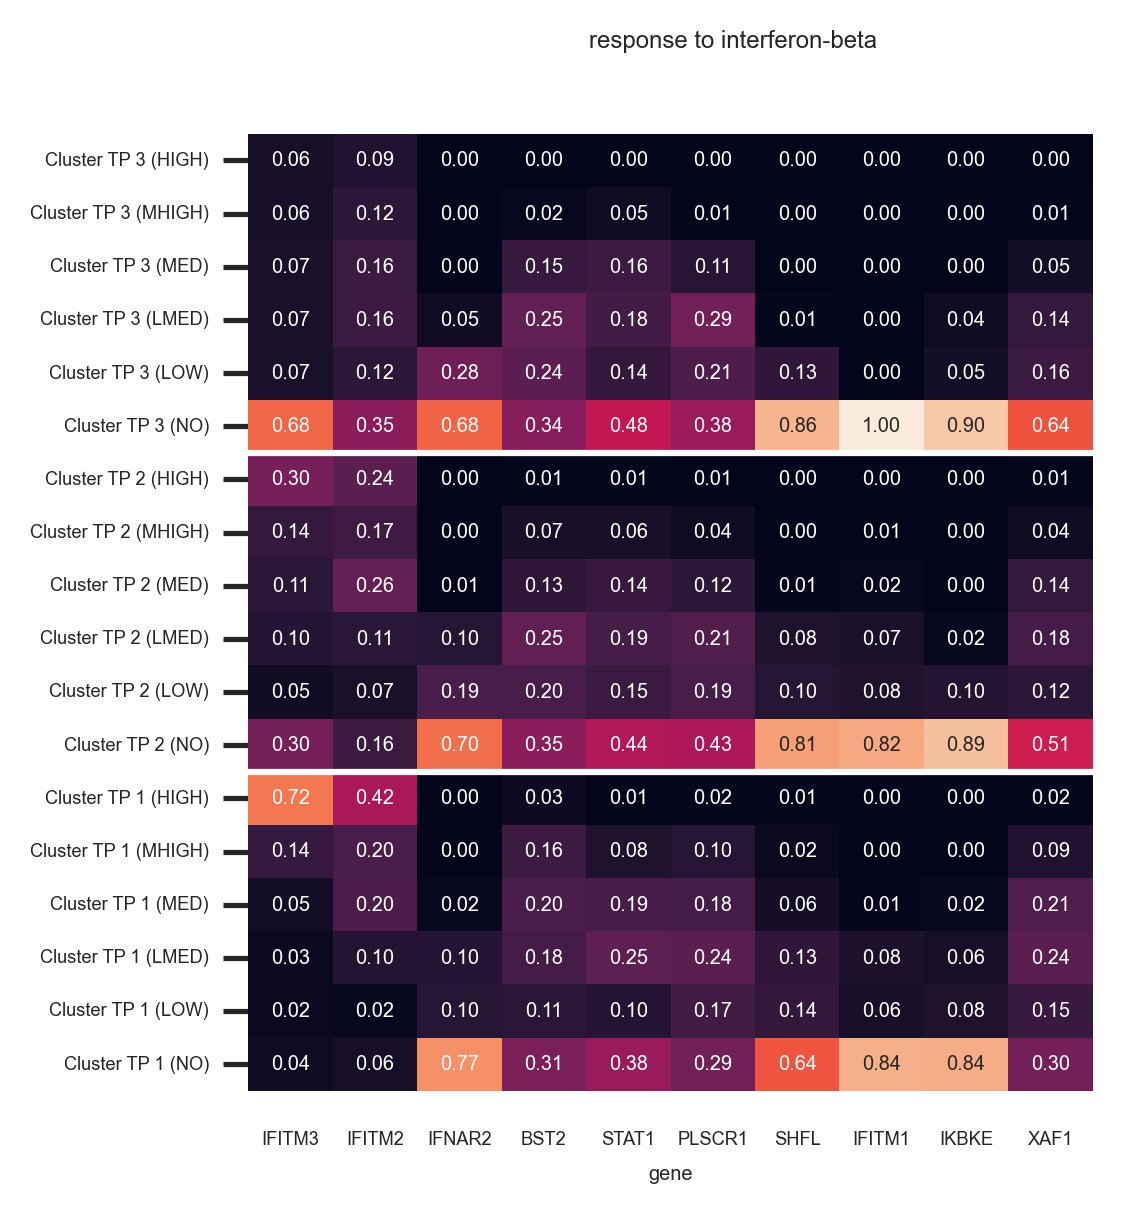

In [24]:
fa.plot_state_memberships(go["GO:0035456"][1], name=go["GO:0035456"][0], figsize=(4,4), outfile="plots/GO_0035456_memberships")